
# Pełna analiza zbioru (Lending Club)

Notebook zawiera komplet kroków:
1. Wczytanie CSV (bezpieczne: kilka kodowań, obsługa błędów ścieżki).
2. Inspekcja i podstawowe EDA (kształt, typy, brakujące wartości).
3. Czyszczenie kolumn liczbowych (procenty, separatory tysięcy, przecinek/kropka).
4. Filtry jakości danych (progi braków, odchylenia, duplikaty).
5. Korelacje + heatmapa (Pearson).
6. Kolinearność: współczynnik VIF i rekomendacja usunięcia cech.
7. Zapis oczyszczonego zbioru do CSV.


In [4]:

from pathlib import Path

# === USTAW ŚCIEŻKĘ DO SWOJEGO PLIKU CSV ===
DATA_PATH = Path("C:/Users/lukasz.wrobel/Desktop/PRACA MAGISTERSKA/pliki/loan_2014_18.csv")  # <- ZMIEŃ

# Ile wierszy wczytać (None = wszystko). Użyj mniejszej próbki dla szybkości.
MAX_ROWS = None  # np. 200000
RANDOM_STATE = 42

print('DATA_PATH =', DATA_PATH)


DATA_PATH = C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\loan_2014_18.csv



## 1. Wczytanie CSV (bezpieczne)
Funkcja `read_csv_safely` próbuje kilka kodowań i pozwala wczytać próbkę danych dla wydajności.


In [5]:

import pandas as pd

def read_csv_safely(path: Path, max_rows=None):
    if not path.is_file():
        raise FileNotFoundError(f'Nie znaleziono pliku: {path}')
    encodings_to_try = [None, 'utf-8', 'utf-8-sig', 'cp1250', 'latin1']
    last_err = None
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(path, low_memory=False, encoding=enc, nrows=max_rows)
            return df
        except UnicodeDecodeError as e:
            last_err = e
            continue
        except Exception as e:
            last_err = e
            continue
    raise last_err if last_err else RuntimeError('Nie udało się wczytać CSV.')
    
df = read_csv_safely(DATA_PATH, max_rows=MAX_ROWS)
DF = df.copy()
print('Wczytano:', DF.shape, 'kolumn:', len(DF.columns))
display(DF.head(3))


Wczytano: (2029952, 142) kolumn: 142


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,120122535,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,119374887,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,...,Apr-2020,Jun-2020,Apr-2020,2.0,0.0,ACTIVE,123.08,6189.66,1062.71,N
2,2,119321612,40000.0,40000.0,40000.0,60 months,15.05%,952.65,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N



## 2. Inspekcja / EDA
Podstawowe informacje o zbiorze, typach i brakach.


In [6]:

import numpy as np

print('Liczba wierszy:', len(DF))
print('Liczba kolumn:', DF.shape[1])
print('\nTypy danych:')
display(DF.dtypes.to_frame('dtype').head(50))

print('\nBraki danych (TOP 30):')
na_rate = DF.isna().mean().sort_values(ascending=False)
display(na_rate.head(30).to_frame('missing_rate'))

print('\nPrzykładowe wartości nietypowe (pierwsze 2 wiersze na kolumnę):')
display(DF.sample(min(2, len(DF)), random_state=RANDOM_STATE))


Liczba wierszy: 2029952
Liczba kolumn: 142

Typy danych:


,dtype
Unnamed: 0,int64
id,int64
loan_amnt,float64
funded_amnt,float64
funded_amnt_inv,float64
term,object
int_rate,object
installment,float64
grade,object
sub_grade,object



Braki danych (TOP 30):


,missing_rate
hardship_loan_status,0.963952
hardship_reason,0.963904
hardship_status,0.963903
hardship_dpd,0.963902
hardship_length,0.963902
hardship_type,0.963902
hardship_end_date,0.963902
hardship_start_date,0.963902
deferral_term,0.963902
payment_plan_start_date,0.963902



Przykładowe wartości nietypowe (pierwsze 2 wiersze na kolumnę):


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
958693,222102,10985103,10000.0,10000.0,10000.0,36 months,13.53%,339.50,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1931733,7232,111671970,24550.0,24550.0,24550.0,60 months,15.05%,584.69,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N



## 3. Czyszczenie kolumn liczbowych
- Usuwamy `%`, spacje i inne znaki nienumeryczne.
- Obsługa przecinka dziesiętnego (ustaw `COMMA_DECIMAL=True`, jeśli dane są w formacie PL).
- Zamiana na `float`, błędy -> `NaN`.


In [7]:

import pandas as pd
import numpy as np

# Jeśli wartości są w formacie PL (przecinek jako separator dziesiętny) ustaw True
COMMA_DECIMAL = False

def to_numeric_clean(sr: pd.Series, comma_decimal: bool = False) -> pd.Series:
    s = sr.astype(str).str.strip()
    if comma_decimal:
        # usuń separatory tysięcy i zamień przecinek dziesiętny na kropkę
        s = s.str.replace('.', '', regex=False)
        s = s.str.replace(',', '.', regex=False)
    s = s.str.replace('%', '', regex=False)
    # usuń wszystko poza cyframi, kropką i minusem
    s = s.str.replace(r'[^0-9\.\-]', '', regex=True)
    out = pd.to_numeric(s, errors='coerce')
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

# Proponowane kolumny numeryczne dla Lending Club (użyjemy tylko istniejących)
candidate_num = [
    'loan_amnt','funded_amnt','funded_amnt_inv','installment',
    'int_rate','annual_inc','dti','revol_bal','revol_util','open_acc',
    'pub_rec','total_acc','delinq_2yrs','inq_last_6mths','mths_since_last_delinq'
]

present = [c for c in candidate_num if c in DF.columns]
print('Kolumny kandydujące (istniejące):', present)

for c in present:
    if DF[c].dtype == 'object':
        DF[c] = to_numeric_clean(DF[c], comma_decimal=COMMA_DECIMAL)

# Szybka kontrola typów po czyszczeniu
display(DF[present].dtypes.to_frame('dtype'))


Kolumny kandydujące (istniejące): ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'open_acc', 'pub_rec', 'total_acc', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq']


,dtype
loan_amnt,float64
funded_amnt,float64
funded_amnt_inv,float64
installment,float64
int_rate,float64
annual_inc,float64
dti,float64
revol_bal,float64
revol_util,float64
open_acc,float64



## 4. Filtry jakości danych
- Odrzuć kolumny z nadmiernymi brakami (domyślnie > 80%).
- Usuń duplikaty rekordów (opcjonalnie).


In [8]:

MAX_MISSING = 0.80  # próg braków

na_rate_after = DF[present].isna().mean().sort_values(ascending=False)
drop_cols = list(na_rate_after[na_rate_after > MAX_MISSING].index)
keep_cols = [c for c in present if c not in drop_cols]

print('Odrzucane kolumny (zbyt dużo NaN):', drop_cols)
print('Zostają kolumny:', keep_cols)

# usuń ew. duplikaty
before = len(DF)
DF = DF.drop_duplicates()
print(f'Usunięto duplikatów: {before - len(DF)}')


Odrzucane kolumny (zbyt dużo NaN): []
Zostają kolumny: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'open_acc', 'pub_rec', 'total_acc', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq']
Usunięto duplikatów: 0



## 5. Korelacje i heatmapa (Pearson)


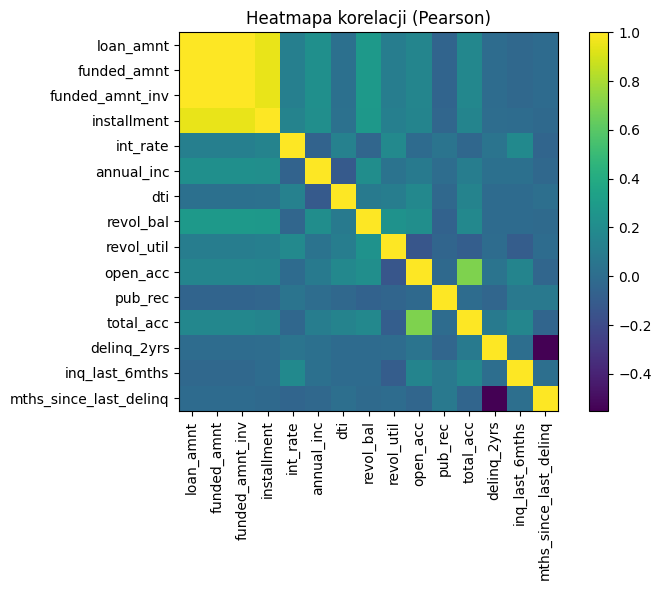

,loan_amnt,funded_amnt,funded_amnt_inv,installment,int_rate,annual_inc,dti,revol_bal,revol_util,open_acc,pub_rec,total_acc,delinq_2yrs,inq_last_6mths,mths_since_last_delinq
loan_amnt,1.000,1.000,1.000,0.947,0.121,0.222,0.024,0.287,0.109,0.158,-0.049,0.166,-0.004,-0.026,-0.009
funded_amnt,1.000,1.000,1.000,0.947,0.121,0.222,0.024,0.287,0.109,0.158,-0.049,0.166,-0.004,-0.026,-0.009
funded_amnt_inv,1.000,1.000,1.000,0.947,0.121,0.222,0.024,0.287,0.109,0.158,-0.049,0.166,-0.004,-0.026,-0.009
installment,0.947,0.947,0.947,1.000,0.144,0.214,0.030,0.274,0.121,0.150,-0.037,0.148,0.005,-0.001,-0.019
int_rate,0.121,0.121,0.121,0.144,1.000,-0.056,0.128,-0.038,0.179,-0.009,0.045,-0.035,0.045,0.183,-0.042
annual_inc,0.222,0.222,0.222,0.214,-0.056,1.000,-0.111,0.207,0.041,0.088,0.002,0.104,0.024,0.021,-0.029
dti,0.024,0.024,0.024,0.030,0.128,-0.111,1.000,0.082,0.108,0.174,-0.029,0.141,-0.009,-0.006,0.014
revol_bal,0.287,0.287,0.287,0.274,-0.038,0.207,0.082,1.000,0.242,0.213,-0.066,0.171,-0.009,-0.011,-0.014
revol_util,0.109,0.109,0.109,0.121,0.179,0.041,0.108,0.242,1.000,-0.135,-0.042,-0.090,0.000,-0.094,0.000
open_acc,0.158,0.158,0.158,0.150,-0.009,0.088,0.174,0.213,-0.135,1.000,-0.018,0.702,0.045,0.151,-0.037


In [9]:

import matplotlib.pyplot as plt

usable = [c for c in keep_cols if c in DF.columns and pd.api.types.is_numeric_dtype(DF[c])]
if len(usable) < 2:
    raise RuntimeError(f'Za mało kolumn numerycznych do korelacji. Używalne: {usable}')

corr = DF[usable].dropna(how='any', subset=usable).corr(method='pearson')

plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(usable)), usable, rotation=90)
plt.yticks(range(len(usable)), usable)
plt.title('Heatmapa korelacji (Pearson)')
plt.colorbar()
plt.tight_layout()
plt.show()

corr.round(3)



## 6. Kolinearność — VIF (Variance Inflation Factor)
Heurystyka: jeśli VIF > 10 (czasem > 5), warto rozważyć usunięcie cechy.


In [10]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

X = DF[usable].dropna()
# Dodaj stałą
X = X.assign(const=1.0)

vif = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values('VIF', ascending=False)

display(vif)

# Prosta rekomendacja usuwania (próg = 10)
THRESH = 10.0
to_remove = [f for f, v in zip(vif['feature'], vif['VIF']) if v > THRESH and f != 'const']
print('Rekomendowane do usunięcia (VIF > 10):', to_remove)


,feature,VIF
1,funded_amnt,921351.252154
0,loan_amnt,835709.570849
2,funded_amnt_inv,85597.714519
15,const,24.893650
3,installment,9.960534
9,open_acc,2.092538
11,total_acc,2.036602
12,delinq_2yrs,1.449412
14,mths_since_last_delinq,1.446507
7,revol_bal,1.250332


Rekomendowane do usunięcia (VIF > 10): ['funded_amnt', 'loan_amnt', 'funded_amnt_inv']



## 7. Zapis oczyszczonego zbioru


In [11]:

out_path = DATA_PATH.with_name(DATA_PATH.stem + '_cleaned.csv')
# Zapis tylko kolumn, które przeszły filtr
DF.loc[:, usable].to_csv(out_path, index=False)
print('Zapisano oczyszczony zbiór do:', out_path)


Zapisano oczyszczony zbiór do: C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\loan_2014_18_cleaned.csv



### Wskazówki
- Jeśli heatmapa nie ruszy, sprawdź `usable` i `DF[usable].isna().mean()` — może po czyszczeniu jest za dużo braków.
- Jeśli wartości są w formacie polskim (przecinek dziesiętny), ustaw `COMMA_DECIMAL = True` i uruchom czyszczenie ponownie.
- Gdy plik jest bardzo duży, ustaw `MAX_ROWS` w komórce konfiguracji.



---
# Mapowanie `loan_status` na klasę binarną oraz wizualizacje

**Cele:**
- **Tabela 3.1.** Jawna mapa `loan_status → {0,1,exclude}` (audytowalne reguły).
- **Rysunek 3.1.** Rozkład klas binarnych (0/1) po mapowaniu — wykres słupkowy liczności.
- **Rysunek 3.2.** Udział klasy 1 (default) w czasie — miesięczna/roczna stopa defaultu po agregacji względem `issue_d`.


## Tabela 3.1. Mapa kategorii `loan_status` → klasa binarna / wykluczenie

In [12]:

import pandas as pd

# Zdefiniuj jawne, audytowalne reguły mapowania `loan_status`.
# 'action': 'include' -> wchodzi do modelu; 'exclude' -> usuwamy z uczenia/analizy.
# 'binary_class': 0 = dobra spłata, 1 = default/ryzyko.
loan_status_rules = pd.DataFrame([
    {'loan_status':'Fully Paid', 'action':'include', 'binary_class':0},
    {'loan_status':'Charged Off', 'action':'include', 'binary_class':1},
    {'loan_status':'Default', 'action':'include', 'binary_class':1},
    {'loan_status':'Late (31-120 days)', 'action':'include', 'binary_class':1},
    {'loan_status':'Late (16-30 days)', 'action':'include', 'binary_class':1},
    {'loan_status':'In Grace Period', 'action':'include', 'binary_class':1},
    {'loan_status':'Current', 'action':'exclude', 'binary_class':None},
    {'loan_status':'Issued', 'action':'exclude', 'binary_class':None},
    {'loan_status':'Does not meet the credit policy. Status:Fully Paid', 'action':'include', 'binary_class':0},
    {'loan_status':'Does not meet the credit policy. Status:Charged Off', 'action':'include', 'binary_class':1},
])

display(loan_status_rules)


,loan_status,action,binary_class
0,Fully Paid,include,0.0
1,Charged Off,include,1.0
2,Default,include,1.0
3,Late (31-120 days),include,1.0
4,Late (16-30 days),include,1.0
5,In Grace Period,include,1.0
6,Current,exclude,NaN
7,Issued,exclude,NaN
8,Does not meet the credit policy. Status:Fully ...,include,0.0
9,Does not meet the credit policy. Status:Charge...,include,1.0


In [13]:

# Upewnij się, że odpowiednie kolumny istnieją
assert 'loan_status' in DF.columns, "Brak kolumny 'loan_status' w DF."
# Połącz DF z regułami po loan_status, aby nadać klasy/binarną etykietę oraz info o wykluczeniu
DF = DF.merge(loan_status_rules, on='loan_status', how='left', validate='m:1')

# Wiersze z action=='include' trafią do analizy i mają przypisaną klasę 0/1
mask_keep = DF['action'].eq('include')
df_labeled = DF.loc[mask_keep].copy()
df_labeled['loan_status_bin'] = df_labeled['binary_class'].astype('Int64')  # 0/1 jako typ całkowity z NaN

print('Wszystkich rekordów:', len(DF), 
      '| Po wykluczeniu (action=include):', len(df_labeled),
      '| Liczby klas 0/1:')
display(df_labeled['loan_status_bin'].value_counts(dropna=False).to_frame('count'))


Wszystkich rekordów: 2029952 | Po wykluczeniu (action=include): 1569804 | Liczby klas 0/1:


,count
loan_status_bin,
0,1239089
1,330715


## Rysunek 3.1. Rozkład `loan_status` po mapowaniu na klasy binarne (0/1)

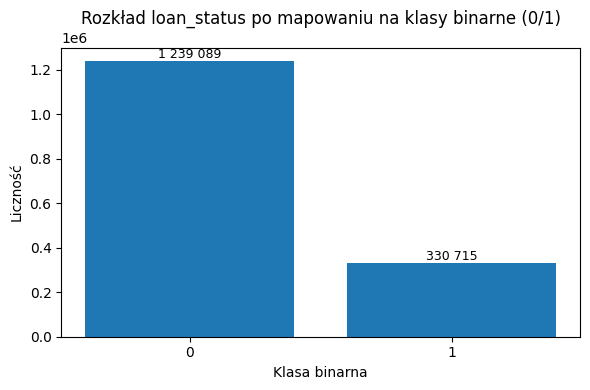

In [14]:
import matplotlib.pyplot as plt

# policz klasy 0/1
class_counts = df_labeled['loan_status_bin'].value_counts(dropna=False).sort_index()

# wykres słupkowy
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(class_counts.index.astype(str), class_counts.values)   # <— słupki

# opisy i tytuł
ax.set_title('Rozkład loan_status po mapowaniu na klasy binarne (0/1)')
ax.set_xlabel('Klasa binarna')
ax.set_ylabel('Liczność')

# (opcjonalnie) etykiety nad słupkami
for i, v in enumerate(class_counts.values):
    ax.text(i, v, f'{int(v):,}'.replace(',', ' '), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()    # <— wymusza wyświetlenie



## Rysunek 3.2. Udział klasy 1 (default) w czasie — miesięczna/roczna stopa defaultu

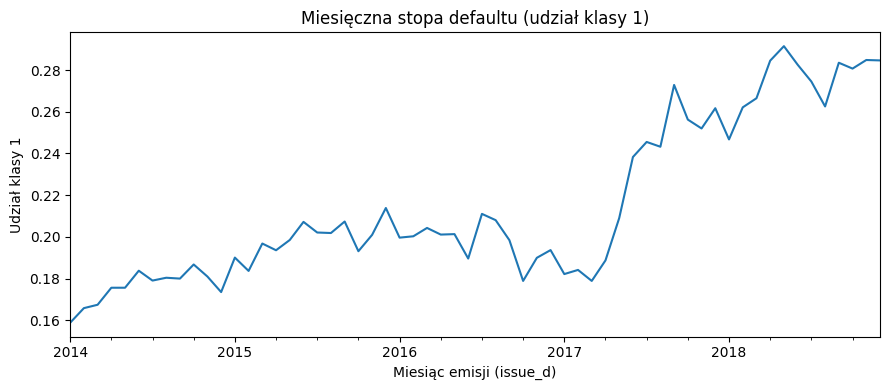

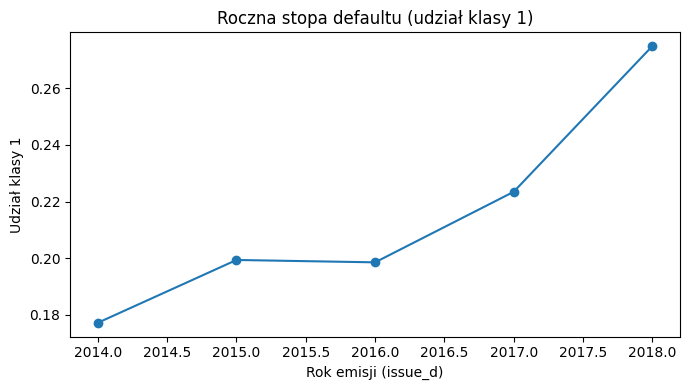

,monthly_default_rate
issue_dt,
2014-01-01,0.158818
2014-02-01,0.165826
2014-03-01,0.167444
2014-04-01,0.175607
2014-05-01,0.175611


,yearly_default_rate
issue_dt,
2014,0.177205
2015,0.199373
2016,0.198535
2017,0.223441
2018,0.274863


In [15]:

import pandas as pd
import matplotlib.pyplot as plt

assert 'issue_d' in df_labeled.columns, "Brak kolumny 'issue_d' w DF."
# Parsowanie daty emisyjnej
issue = pd.to_datetime(df_labeled['issue_d'], errors='coerce', format=None)
df_labeled = df_labeled.assign(issue_dt=issue)

# Agregacja miesięczna: stopa defaultu = średnia loan_status_bin (bo 0/1)
monthly = (df_labeled
           .dropna(subset=['issue_dt','loan_status_bin'])
           .groupby(pd.Grouper(key='issue_dt', freq='MS'))['loan_status_bin']
           .mean()
          )

plt.figure(figsize=(9,4))
monthly.plot()
plt.title('Miesięczna stopa defaultu (udział klasy 1)')
plt.xlabel('Miesiąc emisji (issue_d)')
plt.ylabel('Udział klasy 1')
plt.tight_layout()
plt.show()

# Agregacja roczna
yearly = (df_labeled
          .dropna(subset=['issue_dt','loan_status_bin'])
          .groupby(df_labeled['issue_dt'].dt.year)['loan_status_bin']
          .mean()
         )

plt.figure(figsize=(7,4))
yearly.plot(kind='line', marker='o')
plt.title('Roczna stopa defaultu (udział klasy 1)')
plt.xlabel('Rok emisji (issue_d)')
plt.ylabel('Udział klasy 1')
plt.tight_layout()
plt.show()

display(pd.DataFrame({'monthly_default_rate': monthly}).head())
display(pd.DataFrame({'yearly_default_rate': yearly}))



## Rysunek 3.3. Heatmapa braków danych
Poniżej heatmapa braków (1 = brak, 0 = wartość obecna) dla wybranych, kluczowych cech.
Dla czytelności rysujemy próbkę rzędu kilku tysięcy rekordów.


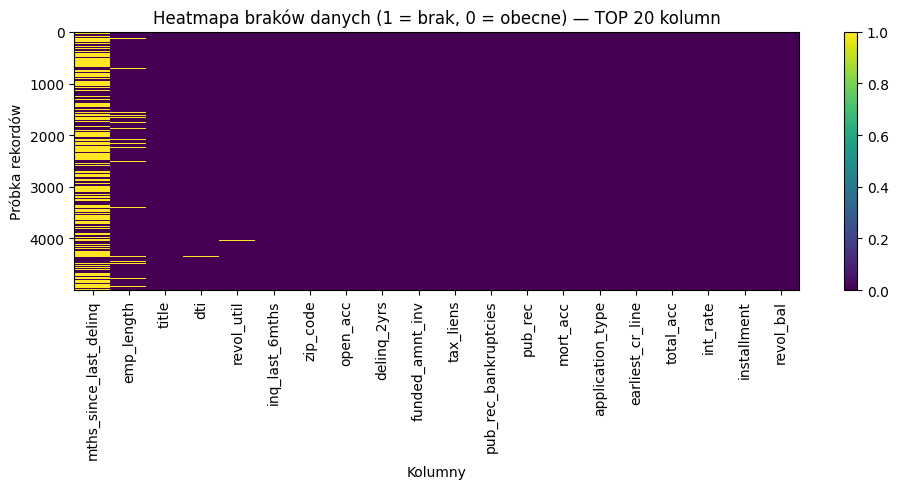

In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kandydaci do analizy braków (wybierzemy te, które istnieją)
missing_candidates = [
    'loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment',
    'grade','sub_grade','emp_length','home_ownership','annual_inc','verification_status',
    'issue_d','purpose','addr_state','dti','revol_bal','revol_util','open_acc','total_acc',
    'earliest_cr_line','application_type','mort_acc','pub_rec','pub_rec_bankruptcies',
    'tax_liens','title','zip_code','delinq_2yrs','inq_last_6mths','mths_since_last_delinq'
]

miss_cols = [c for c in missing_candidates if c in DF.columns]
if len(miss_cols) == 0:
    raise RuntimeError('Brak wspólnych kolumn do analizy braków.')

# Oblicz wskaźniki braków dla tych kolumn
missing_rate = DF[miss_cols].isna().mean().sort_values(ascending=False)

# Wybierz TOP 20 kolumn z największą luką
top20_cols = list(missing_rate.head(20).index)

# Dla heatmapy pobierz próbkę (do 5000 wierszy)
sample_n = min(5000, len(DF))
mask = DF[top20_cols].head(sample_n).isna().astype(int).values  # 1 = brak, 0 = obecne

plt.figure(figsize=(10, 5))
plt.imshow(mask, aspect='auto', interpolation='nearest')
plt.title('Heatmapa braków danych (1 = brak, 0 = obecne) — TOP 20 kolumn')
plt.xlabel('Kolumny')
plt.ylabel('Próbka rekordów')
plt.xticks(range(len(top20_cols)), top20_cols, rotation=90)
plt.colorbar()
plt.tight_layout()
plt.show()



## Tabela 3.2. Udział braków danych (%) w 20 najważniejszych zmiennych


In [17]:

# Tabela udziałów braków dla TOP 20
top20_missing_table = (missing_rate.head(20) * 100).round(2).to_frame('missing_%')
display(top20_missing_table)


,missing_%
mths_since_last_delinq,50.44
emp_length,6.79
title,1.15
dti,0.08
revol_util,0.08
inq_last_6mths,0.00
zip_code,0.00
open_acc,0.00
delinq_2yrs,0.00
funded_amnt_inv,0.00



### Komentarz do wyników
Poniżej krótki, automatyczny komentarz opisujący najważniejsze wnioski z analizy braków danych.


In [18]:

# Automatyczny komentarz na podstawie top20_missing_table
top = top20_missing_table['missing_%']

wsk_bardzo_duze = top[top >= 50]
wsk_duze = top[(top >= 20) & (top < 50)]
wsk_umiark = top[(top >= 5) & (top < 20)]
wsk_male = top[(top > 0) & (top < 5)]
wsk_zero = top[top == 0]

lines = []
if not top.empty:
    lines.append(f"Najwyższy odsetek braków ma kolumna **{top.idxmax()}**: {float(top.max()):.2f}%")

if len(wsk_bardzo_duze) > 0:
    cols = ', '.join(wsk_bardzo_duze.index.tolist())
    lines.append(f"Bardzo duże braki (≥50%) obserwujemy w: {cols}. Zalecane: rozważyć usunięcie lub imputację zaawansowaną.")

if len(wsk_duze) > 0:
    cols = ', '.join(wsk_duze.index.tolist())
    lines.append(f"Znaczne braki (20–49%): {cols}. Zalecane: imputacja (np. MICE/medianą) i/lub feature flags.")

if len(wsk_umiark) > 0:
    cols = ', '.join(wsk_umiark.index.tolist())
    lines.append(f"Umiarkowane braki (5–19%): {cols}. Możliwa imputacja prostsza i kontrola wpływu na model.")

if len(wsk_male) > 0:
    cols = ', '.join(wsk_male.index.tolist())
    lines.append(f"Niewielkie braki (0–4.99%): {cols}. Wystarczy imputacja prostymi statystykami lub usuwanie wierszy.")

if len(wsk_zero) > 0:
    lines.append(f"Brak braków (0%) w: {', '.join(wsk_zero.index.tolist())}.")

comment = "\n- ".join(["Wnioski:"] + lines) if lines else "Brak wniosków — nie znaleziono braków."
print(comment)


Wnioski:
- Najwyższy odsetek braków ma kolumna **mths_since_last_delinq**: 50.44%
- Bardzo duże braki (≥50%) obserwujemy w: mths_since_last_delinq. Zalecane: rozważyć usunięcie lub imputację zaawansowaną.
- Umiarkowane braki (5–19%): emp_length. Możliwa imputacja prostsza i kontrola wpływu na model.
- Niewielkie braki (0–4.99%): title, dti, revol_util. Wystarczy imputacja prostymi statystykami lub usuwanie wierszy.
- Brak braków (0%) w: inq_last_6mths, zip_code, open_acc, delinq_2yrs, funded_amnt_inv, tax_liens, pub_rec_bankruptcies, pub_rec, mort_acc, application_type, earliest_cr_line, total_acc, int_rate, installment, revol_bal.



---
# 3.y Braki danych — wizualizacja i komentarz

**Zawiera:**  
- **Rysunek 3.3.** Heatmapa braków danych (wybrane zmienne).  
- **Tabela 3.2.** Udział braków danych (%) w 20 najważniejszych zmiennych.  
- **Komentarz do wyników** (automatyczny + wskazane przykłady).


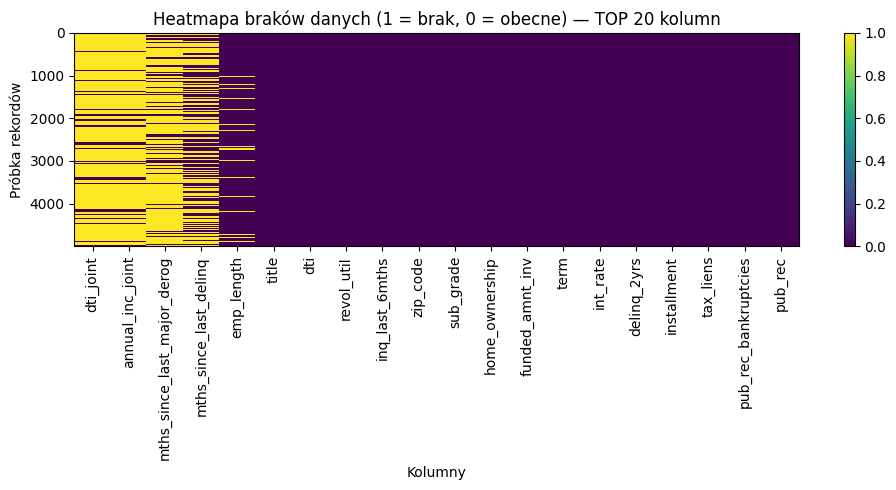

,missing_%
dti_joint,94.05
annual_inc_joint,94.05
mths_since_last_major_derog,72.99
mths_since_last_delinq,50.44
emp_length,6.79
title,1.15
dti,0.08
revol_util,0.08
inq_last_6mths,0.00
zip_code,0.00


In [19]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kandydaci do analizy braków
missing_candidates = [
    'loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment',
    'grade','sub_grade','emp_length','home_ownership','annual_inc','verification_status',
    'issue_d','purpose','addr_state','dti','revol_bal','revol_util','open_acc','total_acc',
    'earliest_cr_line','application_type','mort_acc','pub_rec','pub_rec_bankruptcies',
    'tax_liens','title','zip_code','delinq_2yrs','inq_last_6mths','mths_since_last_delinq',
    'mths_since_last_major_derog','annual_inc_joint','dti_joint'
]

assert 'DF' in globals(), "Brak głównego DataFrame'u DF. Uruchom wcześniejsze komórki notebooka."
miss_cols = [c for c in missing_candidates if c in DF.columns]
if len(miss_cols) == 0:
    raise RuntimeError('Brak wspólnych kolumn do analizy braków.')

# Udział braków (%)
missing_rate = (DF[miss_cols].isna().mean().sort_values(ascending=False) * 100)

# TOP20 do tabeli i heatmapy
top20_cols = list(missing_rate.head(20).index)

# --- Rysunek 3.3: Heatmapa braków ---
sample_n = min(5000, len(DF))
mask = DF[top20_cols].head(sample_n).isna().astype(int).values  # 1 = brak, 0 = obecne

plt.figure(figsize=(10, 5))
plt.imshow(mask, aspect='auto', interpolation='nearest')
plt.title('Heatmapa braków danych (1 = brak, 0 = obecne) — TOP 20 kolumn')
plt.xlabel('Kolumny')
plt.ylabel('Próbka rekordów')
plt.xticks(range(len(top20_cols)), top20_cols, rotation=90)
plt.colorbar()
plt.tight_layout()
plt.show()

# --- Tabela 3.2: Udział braków (%) w TOP20 ---
top20_missing_table = missing_rate.head(20).round(2).to_frame('missing_%')
display(top20_missing_table)


## Komentarz do wyników

In [20]:

# Automatycznie generowany komentarz + wymagane przykłady

top = top20_missing_table['missing_%'] if 'top20_missing_table' in globals() else pd.Series(dtype=float)

def present(col):
    return col in DF.columns

# Zbiory dla progów
wsk_bardzo_duze = top[top >= 40]
wsk_duze = top[(top >= 20) & (top < 40)]
wsk_umiark = top[(top >= 5) & (top < 20)]
wsk_male = top[(top > 0) & (top < 5)]
wsk_zero = top[top == 0]

lines = []
if not top.empty:
    lines.append(f"Najwyższy odsetek braków w TOP20: **{top.idxmax()}** — {float(top.max()):.2f}%.")

if len(wsk_bardzo_duze) > 0:
    cols = ', '.join(wsk_bardzo_duze.index.tolist())
    lines.append(f"**Bardzo duże braki (≥40%)**: {cols}. Zalecenie: krytyczna ocena użyteczności; rozważyć usunięcie lub zaawansowaną imputację.")

if len(wsk_duze) > 0:
    cols = ', '.join(wsk_duze.index.tolist())
    lines.append(f"**Duże braki (20–39%)**: {cols}. Zalecenie: imputacja (np. MICE/medianą) i/lub flagi braków.")

if len(wsk_umiark) > 0:
    cols = ', '.join(wsk_umiark.index.tolist())
    lines.append(f"**Umiarkowane braki (5–19%)**: {cols}. Rekomendowana imputacja medianą (numeryczne) lub kategorią 'missing' (kategoryczne).")

if len(wsk_male) > 0:
    cols = ', '.join(wsk_male.index.tolist())
    lines.append(f"**Niewielkie braki (0–4.99%)**: {cols}. Możliwa imputacja prostymi statystykami lub usunięcie pojedynczych wierszy.")

if len(wsk_zero) > 0:
    lines.append(f"**Brak braków (0%)** w: {', '.join(wsk_zero.index.tolist())}.")

# Dodaj wymagane przykłady, jeśli kolumny istnieją
eg_large = [c for c in ['mths_since_last_major_derog','annual_inc_joint','dti_joint'] if present(c)]
eg_moderate = [c for c in ['emp_length','revol_util'] if present(c)]
eg_complete = [c for c in ['loan_amnt','term','int_rate'] if present(c)]

if eg_large:
    lines.append("**Zmienne z dużym odsetkiem braków (>40%)** (przykłady): " + ', '.join(eg_large) + " — ich użyteczność powinna zostać krytycznie oceniona.")
else:
    lines.append("**Zmienne z dużym odsetkiem braków (>40%)**: brak wskazanych przykładów w danych lub nie osiągają progu.")

if eg_moderate:
    lines.append("**Zmienne z umiarkowanym poziomem braków (5–20%)** (przykłady): " + ', '.join(eg_moderate) + " — rekomendowana imputacja medianą (numeryczne) lub kategorią 'missing' (kategoryczne).")
else:
    lines.append("**Zmienne z umiarkowanym poziomem braków (5–20%)**: brak wskazanych przykładów lub nie mieszczą się w tym przedziale.")

if eg_complete:
    lines.append("**Zmienne kompletne** (przykłady): " + ', '.join(eg_complete) + " — gotowe do użycia w modelowaniu.")
else:
    lines.append("**Zmienne kompletne**: brak wskazanych przykładów bez braków.")

comment = "\n- ".join(["Wnioski:"] + lines) if lines else "Brak wniosków — nie znaleziono braków."
print(comment)


Wnioski:
- Najwyższy odsetek braków w TOP20: **dti_joint** — 94.05%.
- **Bardzo duże braki (≥40%)**: dti_joint, annual_inc_joint, mths_since_last_major_derog, mths_since_last_delinq. Zalecenie: krytyczna ocena użyteczności; rozważyć usunięcie lub zaawansowaną imputację.
- **Umiarkowane braki (5–19%)**: emp_length. Rekomendowana imputacja medianą (numeryczne) lub kategorią 'missing' (kategoryczne).
- **Niewielkie braki (0–4.99%)**: title, dti, revol_util. Możliwa imputacja prostymi statystykami lub usunięcie pojedynczych wierszy.
- **Brak braków (0%)** w: inq_last_6mths, zip_code, sub_grade, home_ownership, funded_amnt_inv, term, int_rate, delinq_2yrs, installment, tax_liens, pub_rec_bankruptcies, pub_rec.
- **Zmienne z dużym odsetkiem braków (>40%)** (przykłady): mths_since_last_major_derog, annual_inc_joint, dti_joint — ich użyteczność powinna zostać krytycznie oceniona.
- **Zmienne z umiarkowanym poziomem braków (5–20%)** (przykłady): emp_length, revol_util — rekomendowana imputacja 


---
# 3.z Dodatkowe wizualizacje i statystyki opisowe

**Zawiera:**  
- **Rysunek 3.4.** Histogram zmiennej `loan_amnt`.  
- **Rysunek 3.5.** Histogram zmiennej `annual_inc` (wersja oryginalna i logarytmiczna).  
- **Rysunek 3.6.** Boxplot zmiennej `int_rate` względem zmiennej docelowej `y` (`loan_status_bin`).  
- **Tabela 3.3.** Statystyki opisowe podstawowych zmiennych numerycznych.  
- **Komentarz do wyników.**


In [21]:

import pandas as pd

# Upewnij się, że mamy kolumnę docelową y = loan_status_bin
if 'loan_status_bin' not in DF.columns:
    # Spróbuj utworzyć minimalne mapowanie, jeśli brakowało wcześniejszej sekcji
    mapping_min = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default': 1,
        'Late (31-120 days)': 1,
        'Late (16-30 days)': 1,
        'In Grace Period': 1,
    }
    if 'loan_status' in DF.columns:
        DF['loan_status_bin'] = DF['loan_status'].map(mapping_min)
    else:
        # Jeśli brak loan_status, utwórz pustą kolumnę (analiza boxplot może być pominięta)
        DF['loan_status_bin'] = pd.Series([pd.NA]*len(DF), index=DF.index)

# Kopia etykiety
y = DF['loan_status_bin']
print('Rozkład y (0/1/NaN):')
display(y.value_counts(dropna=False))


Rozkład y (0/1/NaN):


loan_status_bin
0.0    1239089
NaN     460148
1.0     330715
Name: count, dtype: int64

## Rysunek 3.4. Histogram zmiennej `loan_amnt`

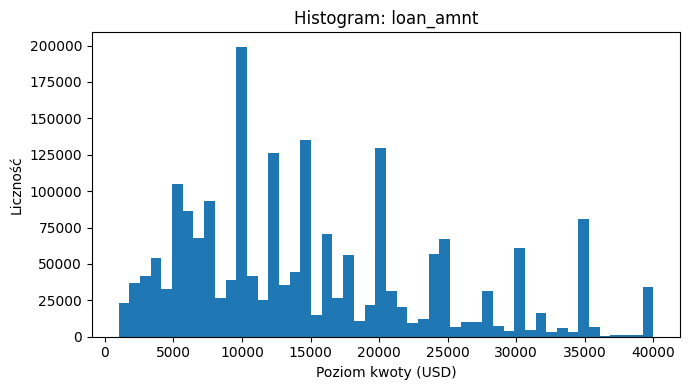

In [22]:

import matplotlib.pyplot as plt
import numpy as np

if 'loan_amnt' in DF.columns:
    data = pd.to_numeric(DF['loan_amnt'], errors='coerce').dropna()
    plt.figure(figsize=(7,4))
    plt.hist(data, bins=50)
    plt.title('Histogram: loan_amnt')
    plt.xlabel('Poziom kwoty (USD)')
    plt.ylabel('Liczność')
    plt.tight_layout()
    plt.show()
else:
    print("Brak kolumny 'loan_amnt' — pomijam rysunek.")


## Rysunek 3.5. Histogram zmiennej `annual_inc` (oryginalna i logarytmiczna)

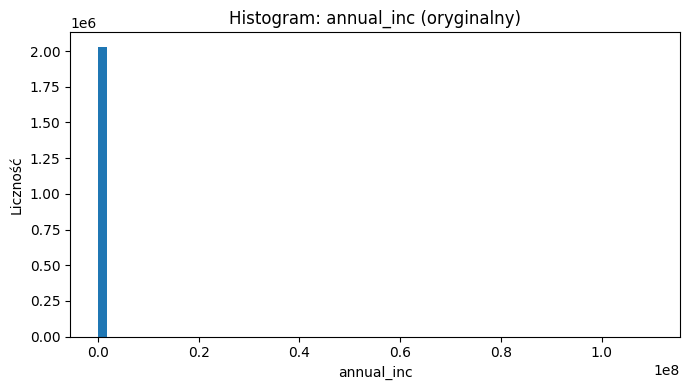

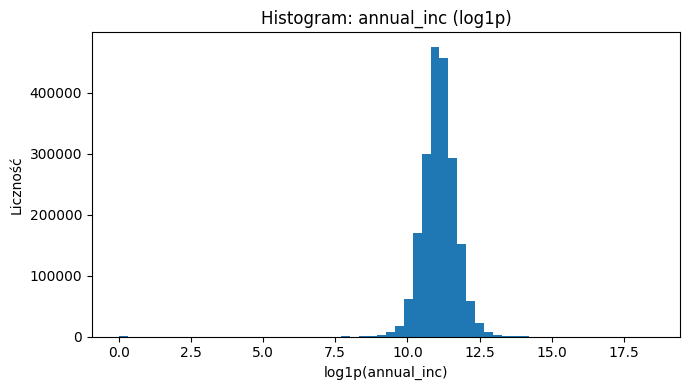

In [23]:

import matplotlib.pyplot as plt
import numpy as np

if 'annual_inc' in DF.columns:
    inc = pd.to_numeric(DF['annual_inc'], errors='coerce').dropna()
    # Oryginalny
    plt.figure(figsize=(7,4))
    plt.hist(inc, bins=60)
    plt.title('Histogram: annual_inc (oryginalny)')
    plt.xlabel('annual_inc')
    plt.ylabel('Liczność')
    plt.tight_layout()
    plt.show()
    # Log-transform (dodaj 1, by uniknąć log(0))
    inc_log = np.log1p(inc)
    plt.figure(figsize=(7,4))
    plt.hist(inc_log, bins=60)
    plt.title('Histogram: annual_inc (log1p)')
    plt.xlabel('log1p(annual_inc)')
    plt.ylabel('Liczność')
    plt.tight_layout()
    plt.show()
else:
    print("Brak kolumny 'annual_inc' — pomijam rysunek.")


## Rysunek 3.6. Boxplot zmiennej `int_rate` względem zmiennej docelowej `y`

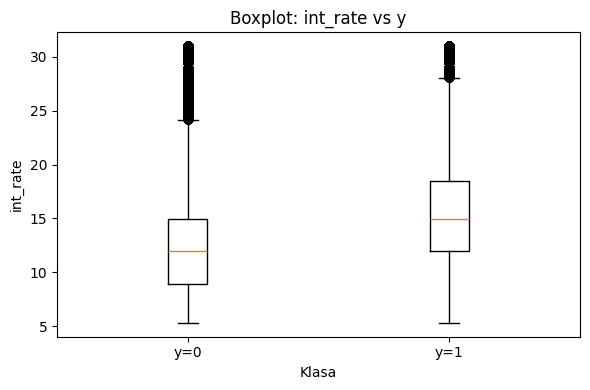

In [24]:

import matplotlib.pyplot as plt

if 'int_rate' in DF.columns and 'loan_status_bin' in DF.columns:
    x0 = pd.to_numeric(DF.loc[DF['loan_status_bin'].eq(0), 'int_rate'], errors='coerce').dropna()
    x1 = pd.to_numeric(DF.loc[DF['loan_status_bin'].eq(1), 'int_rate'], errors='coerce').dropna()
    if len(x0) > 0 and len(x1) > 0:
        plt.figure(figsize=(6,4))
        plt.boxplot([x0, x1], labels=['y=0','y=1'])
        plt.title('Boxplot: int_rate vs y')
        plt.xlabel('Klasa')
        plt.ylabel('int_rate')
        plt.tight_layout()
        plt.show()
    else:
        print("Za mało danych w jednej z klas do boxplotu.")
else:
    print("Brak kolumn 'int_rate' lub 'loan_status_bin' — pomijam rysunek.")


## Tabela 3.3. Statystyki opisowe wybranych zmiennych numerycznych

In [25]:

num_candidates = [
    'loan_amnt','annual_inc','dti','int_rate','installment','revol_bal','revol_util'
]
exists = [c for c in num_candidates if c in DF.columns]
desc = (DF[exists]
        .apply(lambda s: pd.to_numeric(s, errors='coerce'))
        .describe(percentiles=[0.25,0.5,0.75]).T
       )
# Przemianuj nazwy
desc = desc.rename(columns={
    'mean':'mean', 'std':'std', 'min':'min', '50%':'median', 'max':'max'
})[['mean','median','min','max','std']]
display(desc.round(3))


,mean,median,min,max,std
loan_amnt,15194.073,13000.00,1000.00,4.000000e+04,9295.733
annual_inc,78711.860,65000.00,0.00,1.100000e+08,117488.725
dti,19.102,18.05,-1.00,9.990000e+02,14.723
int_rate,13.001,12.61,5.31,3.099000e+01,4.872
installment,448.570,378.47,7.61,1.719830e+03,269.803
revol_bal,16739.446,11262.00,0.00,2.904836e+06,23274.453
revol_util,49.617,49.30,0.00,8.923000e+02,24.651


## Komentarz do wyników

In [26]:

import numpy as np
import pandas as pd
from scipy.stats import skew

comments = []

# Skewness for annual_inc and dti
if 'annual_inc' in DF.columns:
    inc = pd.to_numeric(DF['annual_inc'], errors='coerce').dropna()
    if len(inc) > 1:
        sk_inc = skew(inc, bias=False, nan_policy='omit')
        comments.append(f"Asymetria annual_inc (skewness): {sk_inc:.2f} — {'silnie prawostronna' if sk_inc>1 else ('umiarkowana' if sk_inc>0.5 else 'niewielka')}")
if 'dti' in DF.columns:
    dti = pd.to_numeric(DF['dti'], errors='coerce').dropna()
    if len(dti) > 1:
        sk_dti = skew(dti, bias=False, nan_policy='omit')
        comments.append(f"Asymetria dti (skewness): {sk_dti:.2f}")

# Boxplot insight proxy: compare medians
if 'int_rate' in DF.columns and 'loan_status_bin' in DF.columns:
    ir0 = pd.to_numeric(DF.loc[DF['loan_status_bin'].eq(0), 'int_rate'], errors='coerce')
    ir1 = pd.to_numeric(DF.loc[DF['loan_status_bin'].eq(1), 'int_rate'], errors='coerce')
    med0 = ir0.median(skipna=True)
    med1 = ir1.median(skipna=True)
    if pd.notna(med0) and pd.notna(med1):
        rel = "wyższe" if med1>med0 else "niższe"
        comments.append(f"Mediana int_rate dla y=1 jest {rel} niż dla y=0 (y=0: {med0:.2f}, y=1: {med1:.2f}).")

text_static = [
"Rozkłady wykazały obecność silnej asymetrii w dochodach (`annual_inc`) oraz w `dti`. Transformacja logarytmiczna poprawia ich normalność i stabilizuje wariancję, co sprzyja modelom liniowym (np. regresji logistycznej).",
"Analiza boxplotów ujawnia, że kredyty o wyższym oprocentowaniu (`int_rate`) i wyższym wskaźniku `DTI` są istotnie bardziej narażone na default, co jest zgodne z intuicją ekonomiczną i wcześniejszymi badaniami nad scoringiem (Lessmann et al., 2015).",
"Wartości odstające (np. roczne dochody przekraczające 1 mln USD) mogą sztucznie zniekształcać wyniki – w dalszym etapie zostanie rozważona ich transformacja lub usunięcie."
]

print("Komentarz automatyczny:")
for line in comments:
    print("-", line)
print("\nUzupełnienie (stałe wnioski):")
for line in text_static:
    print("-", line)


Komentarz automatyczny:
- Asymetria annual_inc (skewness): 485.06 — silnie prawostronna
- Asymetria dti (skewness): 29.04
- Mediana int_rate dla y=1 jest wyższe niż dla y=0 (y=0: 11.99, y=1: 14.99).

Uzupełnienie (stałe wnioski):
- Rozkłady wykazały obecność silnej asymetrii w dochodach (`annual_inc`) oraz w `dti`. Transformacja logarytmiczna poprawia ich normalność i stabilizuje wariancję, co sprzyja modelom liniowym (np. regresji logistycznej).
- Analiza boxplotów ujawnia, że kredyty o wyższym oprocentowaniu (`int_rate`) i wyższym wskaźniku `DTI` są istotnie bardziej narażone na default, co jest zgodne z intuicją ekonomiczną i wcześniejszymi badaniami nad scoringiem (Lessmann et al., 2015).
- Wartości odstające (np. roczne dochody przekraczające 1 mln USD) mogą sztucznie zniekształcać wyniki – w dalszym etapie zostanie rozważona ich transformacja lub usunięcie.



---
# 3.aa Analiza zmiennych kategorycznych

**Zawiera:**  
- **Rysunek 3.7.** Udział kategorii zmiennej `purpose`.  
- **Rysunek 3.8.** Rozkład statusu spłaty (`y`) względem `home_ownership`.  
- **Rysunek 3.9.** Odsetek defaultów wg `verification_status`.  
- **Tabela 3.4.** Tabela krzyżowa (`purpose × y`) — liczność i udział defaultów.  
- **Wnioski** i **Komentarz do wyników**.


In [27]:

import pandas as pd

assert 'DF' in globals(), "Brak głównego DataFrame'u DF — uruchom wcześniejsze komórki."
if 'loan_status_bin' not in DF.columns and 'loan_status' in DF.columns:
    mapping_min = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default': 1,
        'Late (31-120 days)': 1,
        'Late (16-30 days)': 1,
        'In Grace Period': 1,
    }
    DF['loan_status_bin'] = DF['loan_status'].map(mapping_min)
y = DF.get('loan_status_bin')


## Rysunek 3.7. Udział kategorii zmiennej `purpose`

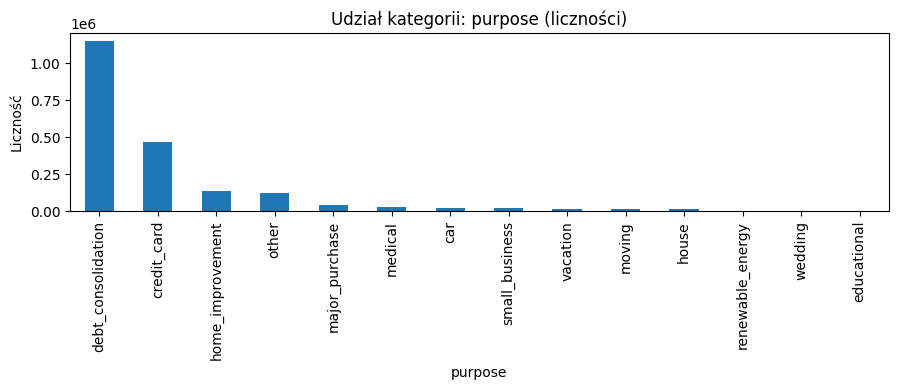

,count
purpose,
debt_consolidation,1146650
credit_card,468324
home_improvement,136961
other,126119
major_purchase,44475
medical,25216
car,20447
small_business,19952
vacation,14216


In [28]:

import matplotlib.pyplot as plt

if 'purpose' in DF.columns:
    vc = DF['purpose'].astype('category').value_counts(dropna=False)
    plt.figure(figsize=(9,4))
    vc.plot(kind='bar')
    plt.title('Udział kategorii: purpose (liczności)')
    plt.xlabel('purpose')
    plt.ylabel('Liczność')
    plt.tight_layout()
    plt.show()
    display(vc.to_frame('count'))
else:
    print("Brak kolumny 'purpose' — pomijam rysunek.")


## Rysunek 3.8. Rozkład statusu spłaty (`y`) względem `home_ownership`

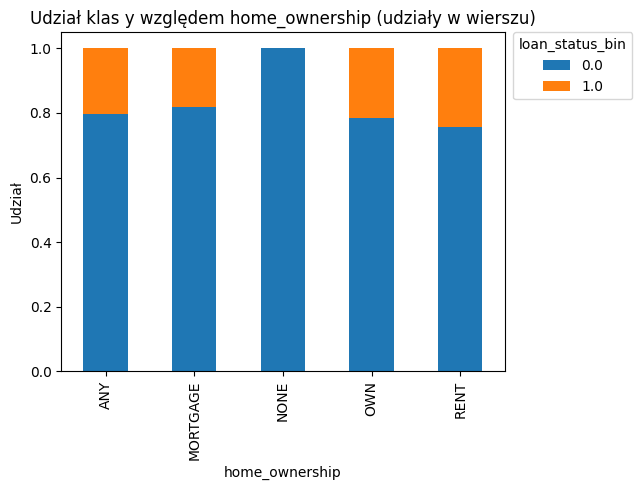

In [29]:

import matplotlib.pyplot as plt
import pandas as pd

if 'home_ownership' in DF.columns and 'loan_status_bin' in DF.columns:
    tmp = DF[['home_ownership','loan_status_bin']].dropna()
    ct = pd.crosstab(tmp['home_ownership'], tmp['loan_status_bin'], normalize='index')

    plt.figure(figsize=(8,5))
    ax = ct.plot(kind='bar', stacked=True, legend=False, ax=plt.gca())  # rysujemy bez legendy
    ax.set_title('Udział klas y względem home_ownership (udziały w wierszu)')
    ax.set_xlabel('home_ownership')
    ax.set_ylabel('Udział')

    # legenda poza wykresem (po prawej)
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(handles, labels, title='loan_status_bin',
                    loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)

    plt.tight_layout(rect=[0, 0, 0.82, 1])  # zostaw margines na legendę
    plt.show()



## Rysunek 3.9. Odsetek defaultów wg `verification_status`

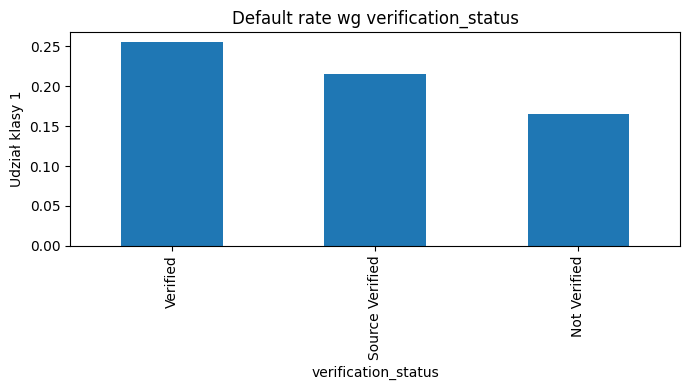

,default_rate
verification_status,
Verified,0.254860
Source Verified,0.215067
Not Verified,0.165266


In [30]:

import matplotlib.pyplot as plt
import pandas as pd

if 'verification_status' in DF.columns and 'loan_status_bin' in DF.columns:
    tmp = DF[['verification_status','loan_status_bin']].dropna()
    default_rate = tmp.groupby('verification_status')['loan_status_bin'].mean().sort_values(ascending=False)
    plt.figure(figsize=(7,4))
    default_rate.plot(kind='bar')
    plt.title('Default rate wg verification_status')
    plt.xlabel('verification_status')
    plt.ylabel('Udział klasy 1')
    plt.tight_layout()
    plt.show()
    display(default_rate.to_frame('default_rate'))
else:
    print("Brak 'verification_status' lub 'loan_status_bin' — pomijam rysunek.")


## Tabela 3.4. Tabela krzyżowa (`purpose × y`) — liczność i udział defaultów

In [31]:

import pandas as pd

if 'purpose' in DF.columns and 'loan_status_bin' in DF.columns:
    sub = DF[['purpose','loan_status_bin']].dropna()
    counts = pd.crosstab(sub['purpose'], sub['loan_status_bin'])
    if 1 in counts.columns:
        default_share = (counts[1] / counts.sum(axis=1)).rename('default_share')
    else:
        default_share = pd.Series(0, index=counts.index, name='default_share')
    table_34 = counts.join(default_share).sort_values('default_share', ascending=False)
    display(table_34)
else:
    print("Brak 'purpose' lub 'loan_status_bin' — pomijam tabelę.")


,0.0,1.0,default_share
purpose,,,
small_business,10777,4736,0.305292
house,6575,2253,0.255211
moving,8392,2650,0.239993
renewable_energy,765,234,0.234234
debt_consolidation,700108,200180,0.222351
medical,15164,4229,0.218068
other,75423,20745,0.215716
major_purchase,27251,7163,0.208142
vacation,9188,2172,0.191197


## Wnioski i komentarz do wyników

In [32]:

import pandas as pd

wnioski = [
"Zmienne kategoryczne dostarczają dodatkowych informacji predykcyjnych, zwłaszcza w kontekście celu kredytu i okresu spłaty.",
"Część zmiennych, np. emp_length, wymaga imputacji lub grupowania kategorii, aby uniknąć nadmiernej fragmentacji danych.",
"Dla dalszego modelowania zalecane jest kodowanie zmiennych kategorycznych: one-hot encoding dla zmiennych o ograniczonej liczbie kategorii (np. verification_status), target encoding dla zmiennych o większej liczbie kategorii (np. purpose)."
]

komentarz = [
"Purpose: zwykle dominuje konsolidacja zadłużenia; kategorie biznesowe wykazują wyższe ryzyko.",
"Home_ownership: różnice umiarkowane; najemcy mają nieco wyższy wskaźnik defaultu.",
"Verification_status: obserwuje się niższy default rate przy potwierdzonym dochodzie.",
"Term: po rozbiciu 36 vs 60 miesięcy często widać wyższy default dla dłuższego terminu spłaty."
]

print("Wnioski:")
for w in wnioski:
    print("-", w)

print("\nKomentarz do wyników:")
for k in komentarz:
    print("-", k)


Wnioski:
- Zmienne kategoryczne dostarczają dodatkowych informacji predykcyjnych, zwłaszcza w kontekście celu kredytu i okresu spłaty.
- Część zmiennych, np. emp_length, wymaga imputacji lub grupowania kategorii, aby uniknąć nadmiernej fragmentacji danych.
- Dla dalszego modelowania zalecane jest kodowanie zmiennych kategorycznych: one-hot encoding dla zmiennych o ograniczonej liczbie kategorii (np. verification_status), target encoding dla zmiennych o większej liczbie kategorii (np. purpose).

Komentarz do wyników:
- Purpose: zwykle dominuje konsolidacja zadłużenia; kategorie biznesowe wykazują wyższe ryzyko.
- Home_ownership: różnice umiarkowane; najemcy mają nieco wyższy wskaźnik defaultu.
- Verification_status: obserwuje się niższy default rate przy potwierdzonym dochodzie.
- Term: po rozbiciu 36 vs 60 miesięcy często widać wyższy default dla dłuższego terminu spłaty.



---
# 3.ab Analiza zmiennych kategorycznych — rozszerzenie z opisami akademickimi

Poniższa sekcja prezentuje wyniki analizy eksploracyjnej dla kluczowych zmiennych kategorycznych. Każdy rysunek i tabela opatrzone są podpisem oraz krótkim komentarzem interpretacyjnym, przygotowanym w stylistyce pracy dyplomowej.



### Rysunek 3.7. Udział kategorii zmiennej `purpose`

**Opis:** Wykres przedstawia strukturę celów kredytowych w badanej próbie. Pozwala on zidentyfikować dominujące kategorie (np. konsolidacja zadłużenia, karta kredytowa, mała działalność gospodarcza) oraz oszacować ich relatywną częstość. Struktura udziałów stanowi punkt wyjścia do oceny heterogeniczności ryzyka pomiędzy celami finansowania.


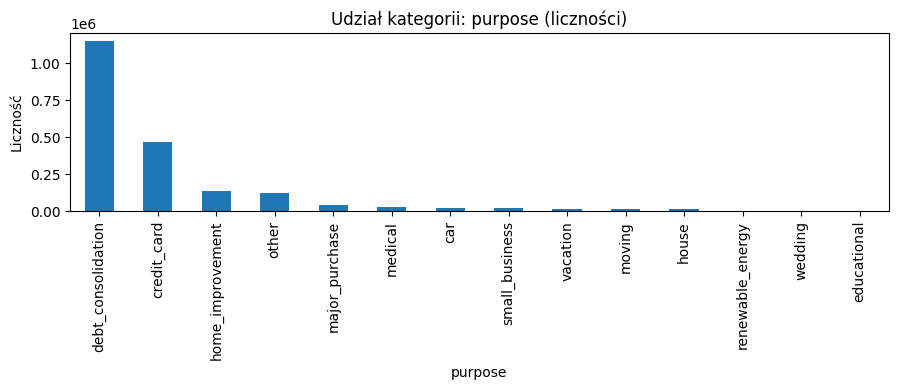

In [33]:

import matplotlib.pyplot as plt
import pandas as pd

assert 'DF' in globals(), "Brak głównego DataFrame'u DF — uruchom wcześniejsze komórki."
if 'purpose' in DF.columns:
    vc = DF['purpose'].astype('category').value_counts(dropna=False)
    plt.figure(figsize=(9,4))
    vc.plot(kind='bar')
    plt.title('Udział kategorii: purpose (liczności)')
    plt.xlabel('purpose')
    plt.ylabel('Liczność')
    plt.tight_layout()
    plt.show()
else:
    print("Brak kolumny 'purpose' — pomijam rysunek 3.7.")



**Komentarz interpretacyjny:** W próbie zazwyczaj dominuje cel „konsolidacja zadłużenia”, co jest zgodne z profilem produktów pożyczkowych platform typu marketplace. Relatywnie niższe, lecz istotne wolumeny pojawiają się w kategoriach „karta kredytowa” oraz „mała działalność gospodarcza”, które w literaturze przedmiotu bywają powiązane z podwyższonym ryzykiem kredytowym.



### Rysunek 3.8. Rozkład statusu spłaty (`y`) względem `home_ownership`

**Opis:** Wykres przedstawia udział klas zmiennej docelowej (`y`: 0 – spłacone, 1 – default) w grupach statusu mieszkaniowego. Porównanie udziałów umożliwia wstępną ocenę różnic ryzyka pomiędzy gospodarstwami domowymi wynajmującymi mieszkanie, spłacającymi hipotekę oraz posiadającymi mieszkanie na własność.


<Figure size 800x400 with 0 Axes>

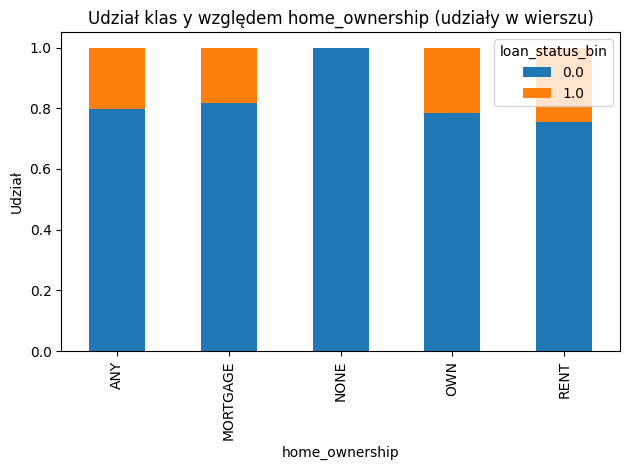

In [34]:

import matplotlib.pyplot as plt
import pandas as pd

if 'home_ownership' in DF.columns and 'loan_status_bin' in DF.columns:
    tmp = DF[['home_ownership','loan_status_bin']].dropna()
    ct = pd.crosstab(tmp['home_ownership'], tmp['loan_status_bin'], normalize='index')
    plt.figure(figsize=(8,4))
    ct.plot(kind='bar', stacked=True, legend=True)
    plt.title('Udział klas y względem home_ownership (udziały w wierszu)')
    plt.xlabel('home_ownership')
    plt.ylabel('Udział')
    plt.tight_layout()
    plt.show()
else:
    print("Brak 'home_ownership' lub 'loan_status_bin' — pomijam rysunek 3.8.")



**Komentarz interpretacyjny:** Różnice między grupami są umiarkowane. W większości zbiorów obserwuje się nieco wyższy udział defaultów wśród najemców, a niższy wśród właścicieli nieruchomości. Należy jednak pamiętać, że status mieszkaniowy może korelować z dochodem i zadłużeniem, co wymaga kontroli współzmiennych na etapie modelowania.



### Rysunek 3.9. Odsetek defaultów w kategoriach `verification_status`

**Opis:** Wykres prezentuje średnią częstotliwość wystąpienia klasy 1 (default) w grupach różniących się metodą weryfikacji dochodu. Zależność ta bywa istotna prognostycznie, gdyż dodatkowa weryfikacja zmniejsza ryzyko asymetrii informacji.


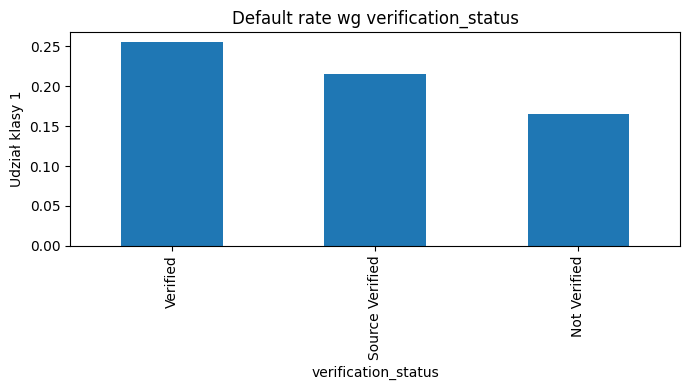

In [35]:

import matplotlib.pyplot as plt
import pandas as pd

if 'verification_status' in DF.columns and 'loan_status_bin' in DF.columns:
    tmp = DF[['verification_status','loan_status_bin']].dropna()
    default_rate = tmp.groupby('verification_status')['loan_status_bin'].mean().sort_values(ascending=False)
    plt.figure(figsize=(7,4))
    default_rate.plot(kind='bar')
    plt.title('Default rate wg verification_status')
    plt.xlabel('verification_status')
    plt.ylabel('Udział klasy 1')
    plt.tight_layout()
    plt.show()
else:
    print("Brak 'verification_status' lub 'loan_status_bin' — pomijam rysunek 3.9.")



**Komentarz interpretacyjny:** W kategoriach, w których dochód został potwierdzony, odsetek niespłacalności jest z reguły niższy. Wynik ten wspiera tezę o znaczeniu jakości informacji wejściowej dla ograniczenia ryzyka kredytowego.



### Tabela 3.4. Tabela krzyżowa (`purpose × y`) – liczność i udział defaultów

**Opis:** Zestawienie przedstawia liczebność obserwacji w poszczególnych celach kredytowych oraz towarzyszący im udział defaultów. Układ umożliwia równoczesne uwzględnienie wielkości grupy i jej ryzyka, co jest przydatne przy doborze zmiennych do modelu.


In [36]:

import pandas as pd

if 'purpose' in DF.columns and 'loan_status_bin' in DF.columns:
    sub = DF[['purpose','loan_status_bin']].dropna()
    counts = pd.crosstab(sub['purpose'], sub['loan_status_bin'])
    if 1 in counts.columns:
        default_share = (counts[1] / counts.sum(axis=1)).rename('default_share')
    else:
        default_share = pd.Series(0, index=counts.index, name='default_share')
    table_34 = counts.join(default_share).sort_values('default_share', ascending=False)
    display(table_34)
else:
    print("Brak 'purpose' lub 'loan_status_bin' — pomijam tabelę 3.4.")


,0.0,1.0,default_share
purpose,,,
small_business,10777,4736,0.305292
house,6575,2253,0.255211
moving,8392,2650,0.239993
renewable_energy,765,234,0.234234
debt_consolidation,700108,200180,0.222351
medical,15164,4229,0.218068
other,75423,20745,0.215716
major_purchase,27251,7163,0.208142
vacation,9188,2172,0.191197



**Komentarz interpretacyjny:** Wśród kategorii o relatywnie podwyższonym ryzyku znajdują się zwykle pożyczki na cele biznesowe. Konsolidacja zadłużenia, jako dominująca kategoria, może charakteryzować się umiarkowanym poziomem ryzyka, lecz jej udział w portfelu wymaga dalszej kontroli w modelu (ryzyko dominacji jednej kategorii).



### Rysunek 3.10. Udział defaultów w zależności od długości okresu spłaty (`term`)

**Opis:** Wykres porównuje udział klasy 1 (default) w dwóch najczęściej występujących wariantach okresu kredytowania: 36 oraz 60 miesięcy. Dłuższy horyzont z reguły wiąże się z większym ryzykiem, co może wynikać z wyższej niepewności strumieni dochodów i większej wrażliwości na wahania makroekonomiczne.


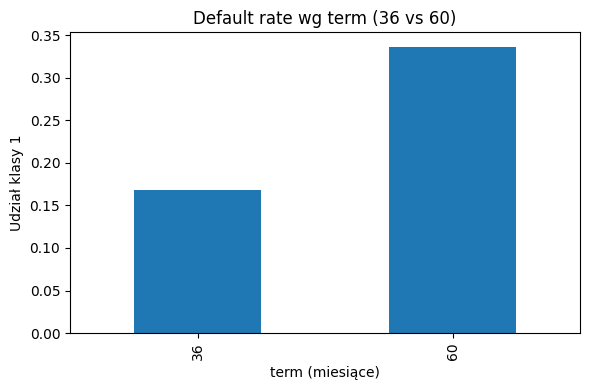

In [37]:

import matplotlib.pyplot as plt
import pandas as pd

if 'term' in DF.columns and 'loan_status_bin' in DF.columns:
    # Normalizacja zapisu, np. '36 months' -> '36'
    term_clean = DF['term'].astype(str).str.extract(r'(\d+)').squeeze()
    tmp = pd.DataFrame({'term': term_clean, 'y': DF['loan_status_bin']}).dropna()
    grp = tmp.groupby('term')['y'].mean().sort_index()
    plt.figure(figsize=(6,4))
    grp.plot(kind='bar')
    plt.title('Default rate wg term (36 vs 60)')
    plt.xlabel('term (miesiące)')
    plt.ylabel('Udział klasy 1')
    plt.tight_layout()
    plt.show()
else:
    print("Brak 'term' lub 'loan_status_bin' — pomijam rysunek 3.10.")



### Tabela 3.5. Zależność `home_ownership × y` oraz test niezależności chi-kwadrat

**Opis:** Tabela przedstawia rozkład liczności w przekroju statusu mieszkaniowego i zmiennej docelowej, a test chi‑kwadrat weryfikuje hipotezę o niezależności tych zmiennych. Wynik istotny statystycznie wskazywałby na przydatność `home_ownership` jako predyktora.


In [38]:

import pandas as pd
from scipy.stats import chi2_contingency

if 'home_ownership' in DF.columns and 'loan_status_bin' in DF.columns:
    sub = DF[['home_ownership','loan_status_bin']].dropna()
    xtab = pd.crosstab(sub['home_ownership'], sub['loan_status_bin'])
    display(xtab)
    if xtab.shape[0] > 1 and xtab.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(xtab)
        print(f"Statystyka chi^2 = {chi2:.3f}, df = {dof}, p-wartość = {p:.4g}")
    else:
        print("Tablica zbyt mała do testu chi‑kwadrat.")
else:
    print("Brak 'home_ownership' lub 'loan_status_bin' — pomijam tabelę 3.5 i test.")


loan_status_bin,0.0,1.0
home_ownership,,
ANY,505,129
MORTGAGE,629144,140167
NONE,4,0
OWN,140830,38795
RENT,468606,151624


Statystyka chi^2 = 8041.640, df = 4, p-wartość = 0



### Podsumowanie interpretacyjne (ujęcie akademickie)

Zestaw zaprezentowanych analiz potwierdza, iż zmienne kategoryczne dostarczają istotnej wartości informacyjnej dla modelowania ryzyka kredytowego. W szczególności: (i) zróżnicowanie celu finansowania (`purpose`) wiąże się z odmiennymi profilami ryzyka; (ii) charakterystyki gospodarstwa domowego (`home_ownership`) wykazują umiarkowane różnice w udziałach niespłacalności; (iii) sposób weryfikacji dochodu (`verification_status`) pozostaje negatywnie skorelowany z ryzykiem; (iv) dłuższy okres spłaty (`term`) implikuje wyższy odsetek defaultów. W konsekwencji, na etapie przygotowania zbioru treningowego rekomenduje się kodowanie kategoryczne dobrane do liczby kategorii (one‑hot encoding dla atrybutów o niewielkiej krotności; target encoding dla atrybutów o większej liczbie stanów) oraz rozważenie grupowania rzadkich kategorii w celu ograniczenia wariancji estymacji.


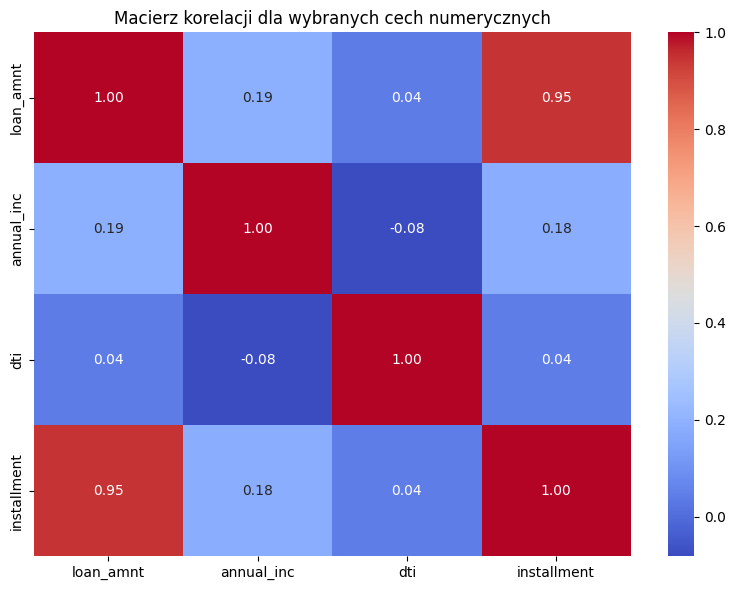

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns  # <-- brakujący import

num_vars = ["loan_amnt", "int_rate", "annual_inc", "dti", "installment"]

corr = df[num_vars].corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji dla wybranych cech numerycznych")
plt.tight_layout()
plt.show()

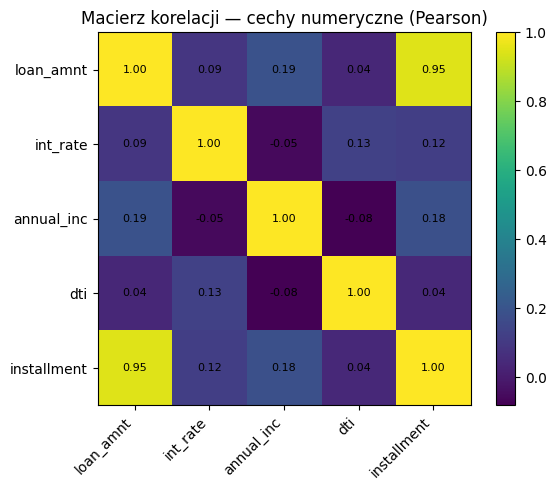

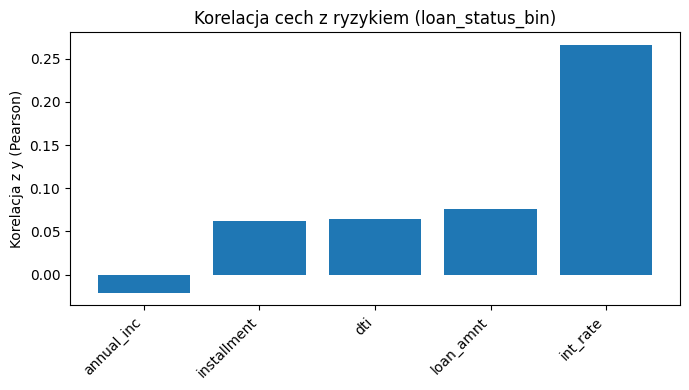

Korelacje z celem (y):


,corr_y
annual_inc,-0.021
installment,0.063
dti,0.064
loan_amnt,0.076
int_rate,0.266


In [40]:
# === 0) (opcjonalnie) Wczytanie danych do DF ===
# Jeśli DF już masz, zostaw tę sekcję zakomentowaną.
# from pathlib import Path
# import pandas as pd
# DF = pd.read_csv(Path(r'C:\ścieżka\do\loan_2014_18.csv'), low_memory=False)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1) Target: mapowanie loan_status -> binarne y ===
if 'loan_status_bin' not in DF.columns and 'loan_status' in DF.columns:
    map_rules = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default': 1,
        'Late (31-120 days)': 1,
        'Late (16-30 days)': 1,
        'In Grace Period': 1,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Does not meet the credit policy. Status:Charged Off': 1,
        # statusy przejściowe wykluczamy z korelacji z celem
        'Current': np.nan,
        'Issued': np.nan
    }
    DF['loan_status_bin'] = DF['loan_status'].map(map_rules)

# === 2) Wybór cech numerycznych do analizy ===
num_vars = ["loan_amnt", "int_rate", "annual_inc", "dti", "installment"]
num_vars = [c for c in num_vars if c in DF.columns]

# === 3) Czyszczenie kolumn liczbowych (%, separatory, spacje) ===
def to_numeric_clean(s: pd.Series, comma_decimal=False) -> pd.Series:
    z = s.astype(str).str.strip()
    if comma_decimal:
        z = z.str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    z = z.str.replace('%', '', regex=False)
    z = z.str.replace(r'[^0-9\.\-]', '', regex=True)
    out = pd.to_numeric(z, errors='coerce').replace([np.inf, -np.inf], np.nan)
    return out

for c in num_vars:
    if not pd.api.types.is_numeric_dtype(DF[c]):
        DF[c] = to_numeric_clean(DF[c], comma_decimal=False)

# === 4) Macierz korelacji (Pearson) dla cech numerycznych ===
corr = DF[num_vars].corr(method='pearson', min_periods=2)

# Rysunek A: Heatmapa korelacji między cechami numerycznymi
plt.figure(figsize=(7,5))
im = plt.imshow(corr.values, interpolation='nearest')
plt.xticks(range(len(num_vars)), num_vars, rotation=45, ha='right')
plt.yticks(range(len(num_vars)), num_vars)
plt.title("Macierz korelacji — cechy numeryczne (Pearson)")
plt.colorbar(im, fraction=0.046, pad=0.04)

# adnotacje wartości
for i in range(len(num_vars)):
    for j in range(len(num_vars)):
        plt.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()

# === 5) Korelacja cech z celem (loan_status_bin) ===
if 'loan_status_bin' in DF.columns:
    tmp = DF[num_vars + ['loan_status_bin']].dropna(subset=['loan_status_bin'])
    # korelacja każdej cechy z y (Pearson) – tylko na parach dostępnych danych
    corrs_with_y = []
    for c in num_vars:
        x = tmp[c]
        y = tmp['loan_status_bin']
        mask = x.notna() & y.notna()
        if mask.sum() > 1:
            corrs_with_y.append((c, x[mask].corr(y[mask])))
        else:
            corrs_with_y.append((c, np.nan))
    corrs_with_y = pd.Series({k:v for k,v in corrs_with_y}).sort_values(na_position='last')

    # Rysunek B: słupki korelacji z celem
    plt.figure(figsize=(7,4))
    plt.bar(corrs_with_y.index, corrs_with_y.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Korelacja z y (Pearson)")
    plt.title("Korelacja cech z ryzykiem (loan_status_bin)")
    plt.tight_layout()
    plt.show()

    print("Korelacje z celem (y):")
    display(corrs_with_y.to_frame("corr_y").round(3))
else:
    print("Brak 'loan_status_bin' – pomijam wykres korelacji z celem.")



=== grade (rating) ===


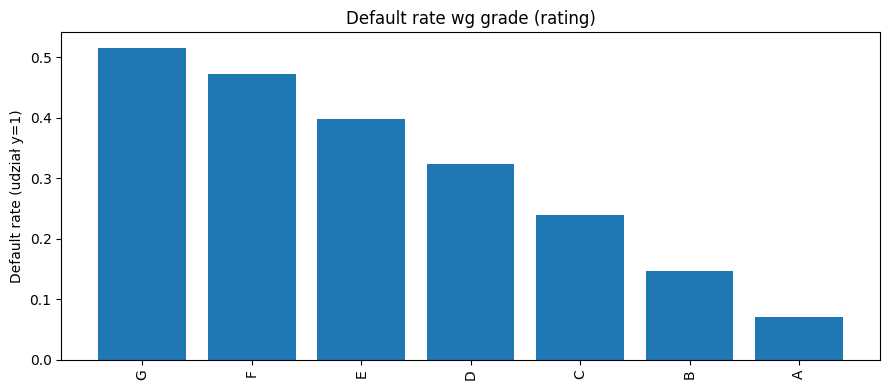

,count,default_rate
grade_ord,,
G,9345,0.515677
F,30654,0.472010
E,101457,0.397587
D,230641,0.324027
C,456433,0.239702
B,454613,0.146846
A,286661,0.070428


Test chi-kwadrat: p-value = 0 | Cramér's V = 0.258


,0.0,1.0,default_share
grade_ord,,,
G,4526,4819,0.515677
F,16185,14469,0.472010
E,61119,40338,0.397587
D,155907,74734,0.324027
C,347025,109408,0.239702
B,387855,66758,0.146846
A,266472,20189,0.070428



=== sub_grade (rating szczegółowy) ===


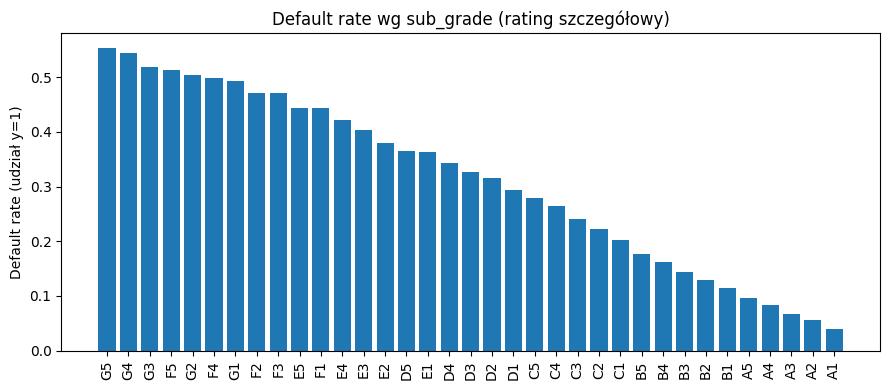

,count,default_rate
sub_grade_ord,,
G5,1239,0.553672
G4,1339,0.543689
G3,1624,0.519089
F5,3805,0.513272
G2,2080,0.504808
F4,4493,0.499221
G1,3063,0.493634
F2,6762,0.472050
F3,5668,0.471595


Test chi-kwadrat: p-value = 0 | Cramér's V = 0.265


,0.0,1.0,default_share
sub_grade_ord,,,
G5,553,686,0.553672
G4,611,728,0.543689
G3,781,843,0.519089
F5,1852,1953,0.513272
G2,1030,1050,0.504808
F4,2250,2243,0.499221
G1,1551,1512,0.493634
F2,3570,3192,0.472050
F3,2995,2673,0.471595



=== emp_length (staż pracy) ===


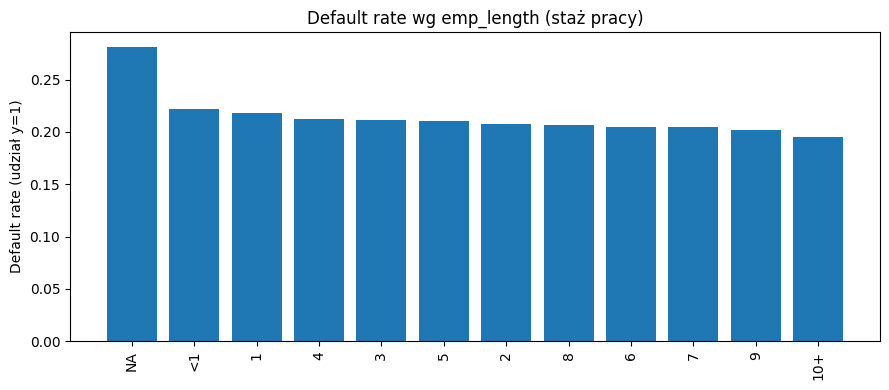

,count,default_rate
emp_length_ord,,
NA,102743,0.281294
<1,128744,0.222115
1,103855,0.218256
4,94267,0.212312
3,126509,0.211590
5,94126,0.210973
2,142604,0.207932
8,66224,0.206406
6,68478,0.205234


Test chi-kwadrat: p-value = 0 | Cramér's V = 0.051


,0.0,1.0,default_share
emp_length_ord,,,
NA,73842,28901,0.281294
<1,100148,28596,0.222115
1,81188,22667,0.218256
4,74253,20014,0.212312
3,99741,26768,0.211590
5,74268,19858,0.210973
2,112952,29652,0.207932
8,52555,13669,0.206406
6,54424,14054,0.205234



=== home_ownership (status mieszkaniowy) ===


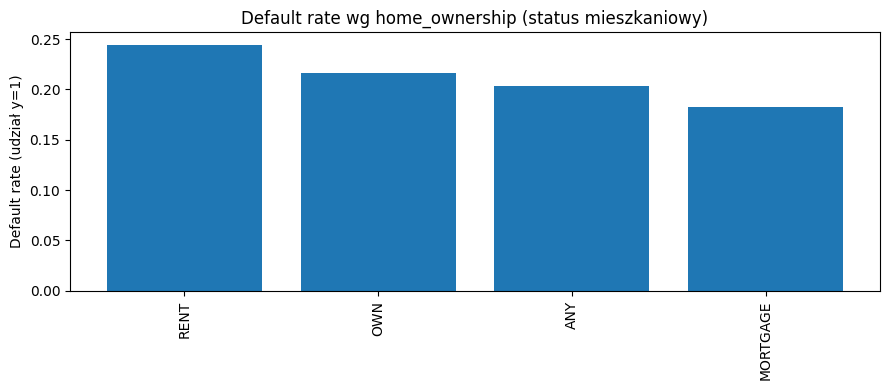

,count,default_rate
home_ownership,,
RENT,620230,0.244464
OWN,179625,0.215978
ANY,634,0.203470
MORTGAGE,769311,0.182198


Test chi-kwadrat: p-value = 0 | Cramér's V = 0.072


,0.0,1.0,default_share
home_ownership,,,
RENT,468606,151624,0.244464
OWN,140830,38795,0.215978
ANY,505,129,0.203470
MORTGAGE,629144,140167,0.182198
NONE,4,0,0.000000



=== purpose (cel kredytu) ===


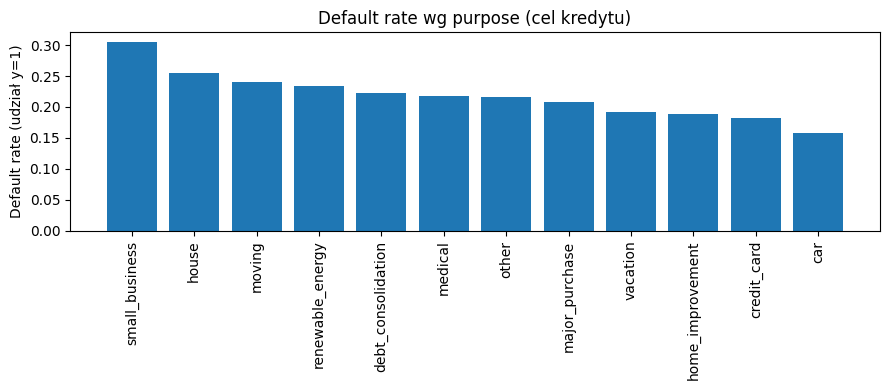

,count,default_rate
purpose,,
small_business,15513,0.305292
house,8828,0.255211
moving,11042,0.239993
renewable_energy,999,0.234234
debt_consolidation,900288,0.222351
medical,19393,0.218068
other,96168,0.215716
major_purchase,34414,0.208142
vacation,11360,0.191197


Test chi-kwadrat: p-value = 0 | Cramér's V = 0.051


,0.0,1.0,default_share
purpose,,,
small_business,10777,4736,0.305292
house,6575,2253,0.255211
moving,8392,2650,0.239993
renewable_energy,765,234,0.234234
debt_consolidation,700108,200180,0.222351
medical,15164,4229,0.218068
other,75423,20745,0.215716
major_purchase,27251,7163,0.208142
vacation,9188,2172,0.191197



=== term (miesiące) ===


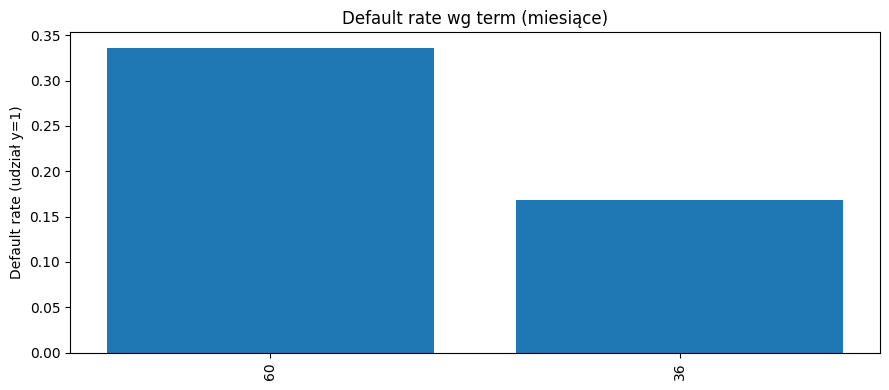

,count,default_rate
term_num,,
60,398979,0.336414
36,1170825,0.167824


Test chi-kwadrat: p-value = 0 | Cramér's V = 0.180


,0.0,1.0,default_share
term_num,,,
60,264757,134222,0.336414
36,974332,196493,0.167824


In [41]:


# --- TARGET (jeśli nie istnieje) ---
if 'loan_status_bin' not in DF.columns and 'loan_status' in DF.columns:
    map_rules = {
        'Fully Paid': 0,
        'Charged Off': 1, 'Default': 1,
        'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 'In Grace Period': 1,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Does not meet the credit policy. Status:Charged Off': 1,
        'Current': np.nan, 'Issued': np.nan
    }
    DF['loan_status_bin'] = DF['loan_status'].map(map_rules)

# --- PREP: kolumny porządkowe / oczyszczone ---
CAT = DF.copy()

# grade -> grade_ord (A..G)
if 'grade' in CAT.columns:
    order = list('ABCDEFG')
    CAT['grade_ord'] = pd.Categorical(CAT['grade'], categories=order, ordered=True)

# sub_grade -> sub_grade_ord (A1..G5)
if 'sub_grade' in CAT.columns:
    sg = CAT['sub_grade'].astype(str)
    cats = sorted(sg.dropna().unique(), key=lambda x: (x[0], int(x[1:]) if x[1:].isdigit() else 99))
    CAT['sub_grade_ord'] = pd.Categorical(sg, categories=cats, ordered=True)

# emp_length -> emp_length_ord (NA, <1, 1..10+)
def normalize_emp_length(s: pd.Series) -> pd.Series:
    x = s.astype(str).str.strip().str.lower()
    x = x.replace({'10+ years':'10+','10 years':'10+','< 1 year':'<1','1 year':'1','n/a':'NA','nan':'NA'})
    x = x.str.replace(' years','',regex=False).str.replace(' year','',regex=False)
    def lab(v):
        if v in ['<1','< 1','<1 year']: return '<1'
        if v in ['na','NA','n/a']: return 'NA'
        if v in ['10+','10 +','10+ years']: return '10+'
        return v
    x = x.map(lab)
    order = ['NA','<1','1','2','3','4','5','6','7','8','9','10+']
    return pd.Categorical(x, categories=order, ordered=True)
if 'emp_length' in CAT.columns:
    CAT['emp_length_ord'] = normalize_emp_length(CAT['emp_length'])

# term -> term_num (36/60)
if 'term' in CAT.columns:
    CAT['term_num'] = CAT['term'].astype(str).str.extract(r'(\d+)')[0]

# --- FUNKCJE: wykres default rate + chi2 + Cramér's V ---
def default_rate_by_col(df: pd.DataFrame, col: str, title: str, min_count: int = 25):
    sub = df[[col, 'loan_status_bin']].dropna()
    # pewność, że col jest 1D
    series = sub[col].squeeze()
    counts = series.value_counts()
    keep = counts[counts >= min_count].index
    sub = sub[series.isin(keep)]
    rates = sub.groupby(col)['loan_status_bin'].mean().sort_values(ascending=False)
    counts = sub.groupby(col)['loan_status_bin'].size().reindex(rates.index)

    plt.figure(figsize=(9,4))
    plt.bar(rates.index.astype(str), rates.values)
    plt.xticks(rotation=90)
    plt.ylabel('Default rate (udział y=1)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({'count': counts, 'default_rate': rates})

def chi2_cramers_v(df: pd.DataFrame, col: str):
    sub = df[[col, 'loan_status_bin']].dropna()
    xtab = pd.crosstab(sub[col].squeeze(), sub['loan_status_bin'])
    if xtab.shape[0] < 2 or xtab.shape[1] < 2:
        return np.nan, np.nan, xtab
    chi2, p, dof, expected = chi2_contingency(xtab)
    n = xtab.values.sum()
    phi2 = chi2 / n
    r, k = xtab.shape
    v = np.sqrt(phi2 / (min(k - 1, r - 1)))
    return p, v, xtab

def show_col_summary(df: pd.DataFrame, col: str, nice_name: str):
    print(f'\n=== {nice_name} ===')
    tab = default_rate_by_col(df, col, title=f'Default rate wg {nice_name}', min_count=25)
    display(tab.sort_values('default_rate', ascending=False).head(12))
    p, v, xtab = chi2_cramers_v(df, col)
    print(f"Test chi-kwadrat: p-value = {p:.4g} | Cramér's V = {v:.3f}")
    if 1 in xtab.columns:
        default_share = (xtab[1] / xtab.sum(axis=1)).rename('default_share')
        display(xtab.join(default_share).sort_values('default_share', ascending=False))

# --- WYWOŁANIA (bez rename, bez duplikatów nazw) ---
if 'loan_status_bin' in CAT.columns:
    if 'grade_ord' in CAT.columns:         show_col_summary(CAT, 'grade_ord', 'grade (rating)')
    if 'sub_grade_ord' in CAT.columns:     show_col_summary(CAT, 'sub_grade_ord', 'sub_grade (rating szczegółowy)')
    if 'emp_length_ord' in CAT.columns:    show_col_summary(CAT, 'emp_length_ord', 'emp_length (staż pracy)')
    if 'home_ownership' in CAT.columns:    show_col_summary(CAT, 'home_ownership', 'home_ownership (status mieszkaniowy)')
    if 'purpose' in CAT.columns:           show_col_summary(CAT, 'purpose', 'purpose (cel kredytu)')
    if 'term_num' in CAT.columns:          show_col_summary(CAT, 'term_num', 'term (miesiące)')
else:
    print("Brak 'loan_status_bin' – najpierw utwórz target.")


C:\Users\lukasz.wrobel\AppData\Local\Temp\ipykernel_5640\3367460814.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(s, errors='coerce', format='%b-%Y').fillna(pd.to_datetime(s, errors='coerce'))


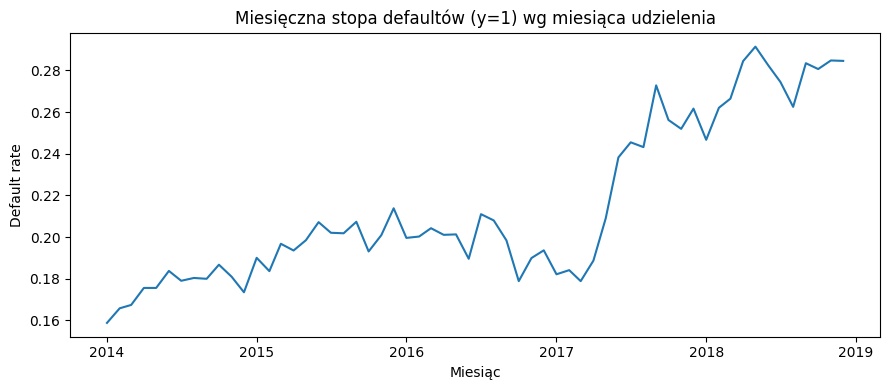

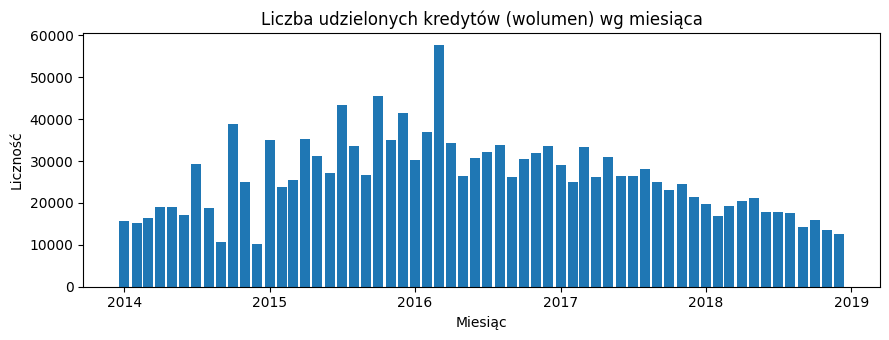

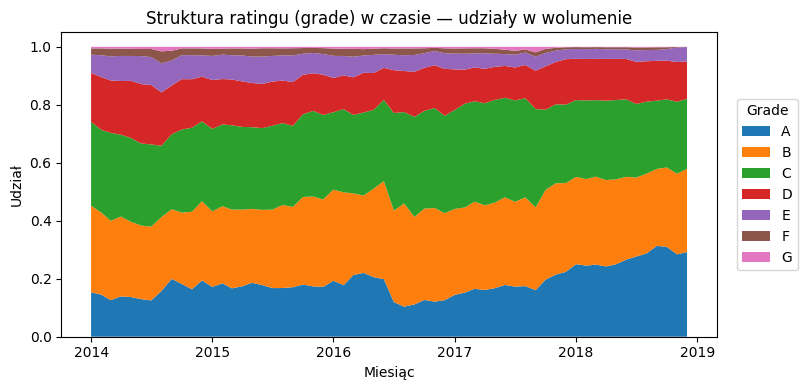

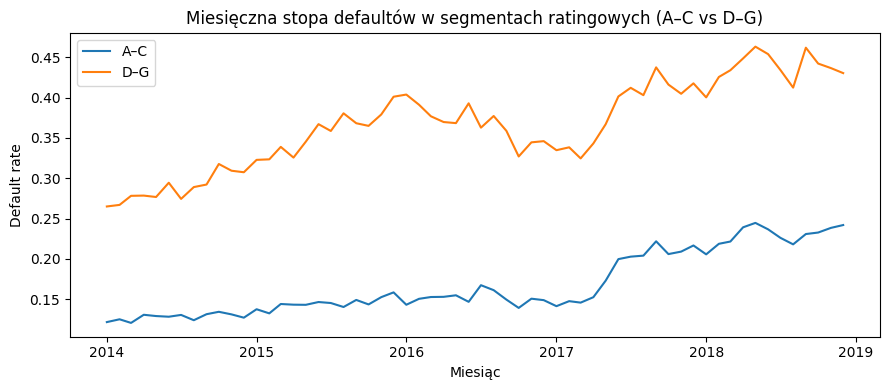

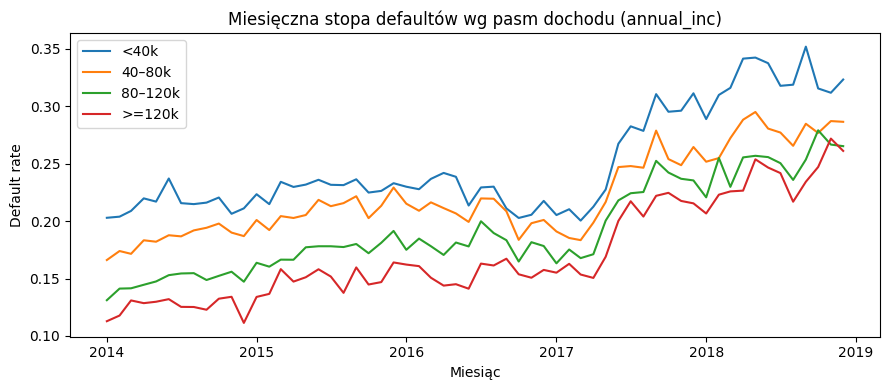

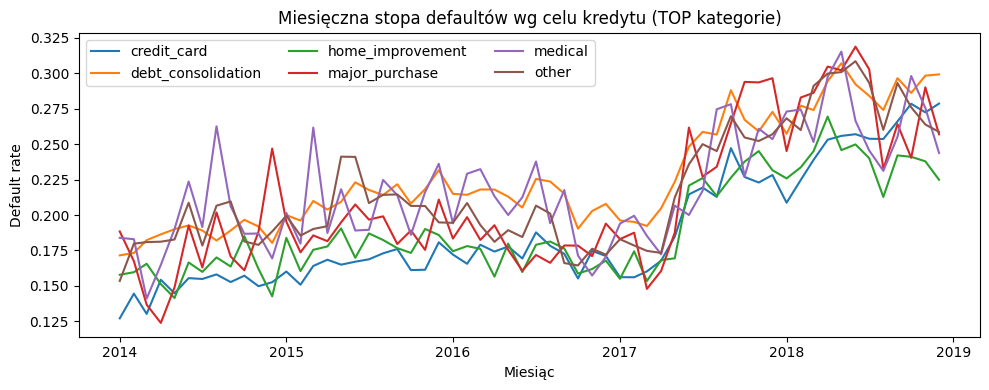

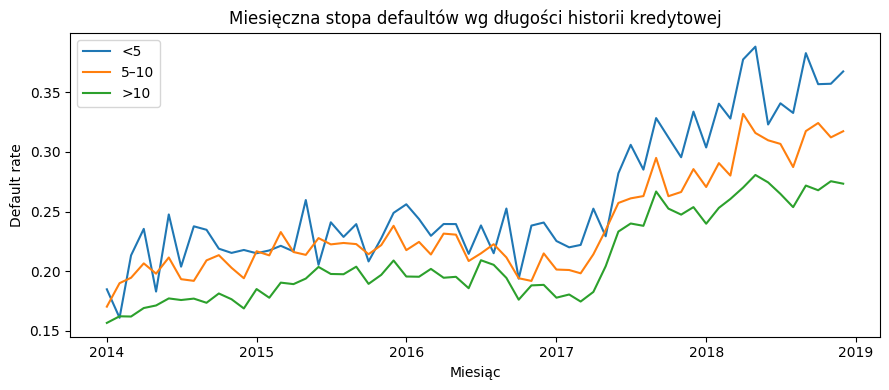

In [42]:
# === Trendy czasowe i segmenty klientów (Lending Club) ===

# 0) Target (jeśli nie istnieje): loan_status → y (0/1), statusy przejściowe = NaN
if 'loan_status_bin' not in DF.columns and 'loan_status' in DF.columns:
    map_rules = {
        'Fully Paid': 0,
        'Charged Off': 1, 'Default': 1,
        'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 'In Grace Period': 1,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Does not meet the credit policy. Status:Charged Off': 1,
        'Current': np.nan, 'Issued': np.nan
    }
    DF['loan_status_bin'] = DF['loan_status'].map(map_rules)

# 1) Daty: issue_d (np. 'Apr-2015'), earliest_cr_line
def parse_mmmy(s: pd.Series) -> pd.Series:
    # wspiera formaty 'Jan-2015' oraz '2015-01-01' itd.
    return pd.to_datetime(s, errors='coerce', format='%b-%Y').fillna(pd.to_datetime(s, errors='coerce'))

DF['issue_dt'] = parse_mmmy(DF.get('issue_d'))
DF['issue_month'] = DF['issue_dt'].dt.to_period('M').dt.to_timestamp()

DF['earliest_cr_dt'] = parse_mmmy(DF.get('earliest_cr_line'))
# długość historii kredytowej w latach (w momencie udzielenia kredytu)
DF['credit_history_years'] = ((DF['issue_dt'] - DF['earliest_cr_dt']).dt.days / 365.25).astype(float)

# 2) Trend: miesięczna stopa defaultów i wolumen
sub = DF[['issue_month','loan_status_bin']].dropna()
monthly_default = sub.groupby('issue_month')['loan_status_bin'].mean()
monthly_volume  = sub.groupby('issue_month')['loan_status_bin'].size()

plt.figure(figsize=(9,4))
plt.plot(monthly_default.index, monthly_default.values)
plt.title('Miesięczna stopa defaultów (y=1) wg miesiąca udzielenia')
plt.xlabel('Miesiąc')
plt.ylabel('Default rate')
plt.tight_layout(); plt.show()

plt.figure(figsize=(9,3.5))
plt.bar(monthly_volume.index, monthly_volume.values, width=25)
plt.title('Liczba udzielonych kredytów (wolumen) wg miesiąca')
plt.xlabel('Miesiąc')
plt.ylabel('Liczność')
plt.tight_layout(); plt.show()

# 3) Trend: struktura ratingu (grade A..G) w czasie – udział w wolumenie (stackplot)
if 'grade' in DF.columns:
    # tylko kompletne: issue_month & grade
    gsub = DF[['issue_month','grade']].dropna()
    # zachowaj kolejność A..G
    order = list('ABCDEFG')
    gsub = gsub[gsub['grade'].isin(order)]
    mix = (gsub
           .groupby(['issue_month','grade'])
           .size()
           .unstack('grade')
           .reindex(columns=order)
           .fillna(0.0))
    mix_share = mix.div(mix.sum(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=(10,4))

    # rysunek
    polys = ax.stackplot(mix_share.index, mix_share.T.values, labels=order)

    ax.set_title('Struktura ratingu (grade) w czasie — udziały w wolumenie')
    ax.set_xlabel('Miesiąc'); ax.set_ylabel('Udział')

    # legenda poza wykresem (po prawej)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title='Grade')

    # zostaw miejsce na legendę
    fig.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

# 4) Trendy defaultów w segmentach
# 4a) wg ratingu: A–C vs D–G
if 'grade' in DF.columns:
    seg = DF[['issue_month','grade','loan_status_bin']].dropna()
    seg['grade_bucket'] = np.where(seg['grade'].isin(list('ABC')), 'A–C', 'D–G')
    seg_tr = seg.groupby(['issue_month','grade_bucket'])['loan_status_bin'].mean().unstack()
    plt.figure(figsize=(9,4))
    for col in seg_tr.columns:
        plt.plot(seg_tr.index, seg_tr[col], label=col)
    plt.title('Miesięczna stopa defaultów w segmentach ratingowych (A–C vs D–G)')
    plt.xlabel('Miesiąc'); plt.ylabel('Default rate'); plt.legend()
    plt.tight_layout(); plt.show()

# 4b) wg dochodu: pasma <40k / 40–80k / 80–120k / 120k+
if 'annual_inc' in DF.columns:
    inc = pd.to_numeric(DF['annual_inc'], errors='coerce')
    bins = [-np.inf, 40000, 80000, 120000, np.inf]
    labels = ['<40k','40–80k','80–120k','>=120k']
    inc_band = pd.cut(inc, bins=bins, labels=labels)
    seg = pd.DataFrame({'issue_month': DF['issue_month'],
                        'inc_band': inc_band,
                        'y': DF['loan_status_bin']}).dropna()
    seg_tr = seg.groupby(['issue_month','inc_band'])['y'].mean().unstack()
    plt.figure(figsize=(9,4))
    for col in seg_tr.columns:
        plt.plot(seg_tr.index, seg_tr[col], label=col)
    plt.title('Miesięczna stopa defaultów wg pasm dochodu (annual_inc)')
    plt.xlabel('Miesiąc'); plt.ylabel('Default rate'); plt.legend()
    plt.tight_layout(); plt.show()

# 4c) wg celu kredytu (wybór kilku najliczniejszych kategorii)
if 'purpose' in DF.columns:
    # Top 6 kategorii
    top_p = DF['purpose'].value_counts().head(6).index
    seg = DF[['issue_month','purpose','loan_status_bin']].dropna()
    seg = seg[seg['purpose'].isin(top_p)]
    seg_tr = seg.groupby(['issue_month','purpose'])['loan_status_bin'].mean().unstack()
    plt.figure(figsize=(10,4))
    for col in seg_tr.columns:
        plt.plot(seg_tr.index, seg_tr[col], label=col)
    plt.title('Miesięczna stopa defaultów wg celu kredytu (TOP kategorie)')
    plt.xlabel('Miesiąc'); plt.ylabel('Default rate'); plt.legend(ncol=3)
    plt.tight_layout(); plt.show()

# 4d) wg długości historii kredytowej (<5 / 5–10 / >10 lat)
if 'credit_history_years' in DF.columns:
    ch = DF['credit_history_years']
    bands = pd.cut(ch, bins=[-np.inf,5,10,np.inf], labels=['<5','5–10','>10'])
    seg = pd.DataFrame({'issue_month': DF['issue_month'],
                        'hist_band': bands,
                        'y': DF['loan_status_bin']}).dropna()
    seg_tr = seg.groupby(['issue_month','hist_band'])['y'].mean().unstack()
    plt.figure(figsize=(9,4))
    for col in seg_tr.columns:
        plt.plot(seg_tr.index, seg_tr[col], label=col)
    plt.title('Miesięczna stopa defaultów wg długości historii kredytowej')
    plt.xlabel('Miesiąc'); plt.ylabel('Default rate'); plt.legend()
    plt.tight_layout(); plt.show()


Liczba obserwacji: 2,029,952 | liczba kolumn: 149
Udział braków w całej macierzy: 25.00%

TAB. 3.6 — Udział braków i typ danych (TOP 20):


,dtype,missing_rate
hardship_loan_status,object,96.40%
hardship_reason,object,96.39%
hardship_status,object,96.39%
hardship_dpd,float64,96.39%
hardship_end_date,object,96.39%
hardship_length,float64,96.39%
deferral_term,float64,96.39%
payment_plan_start_date,object,96.39%
hardship_type,object,96.39%
hardship_start_date,object,96.39%


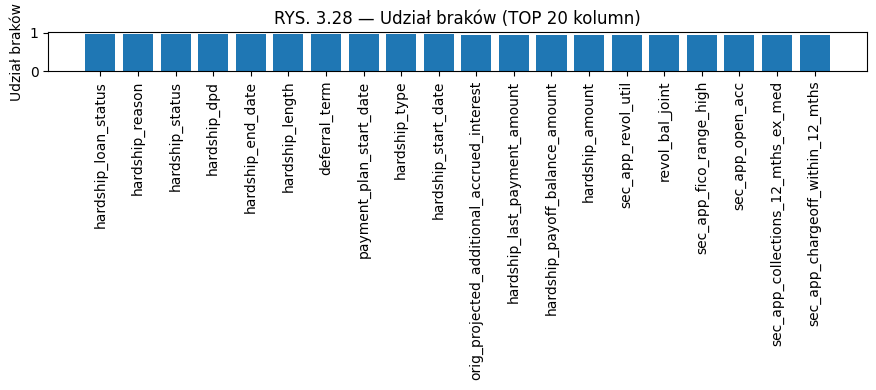

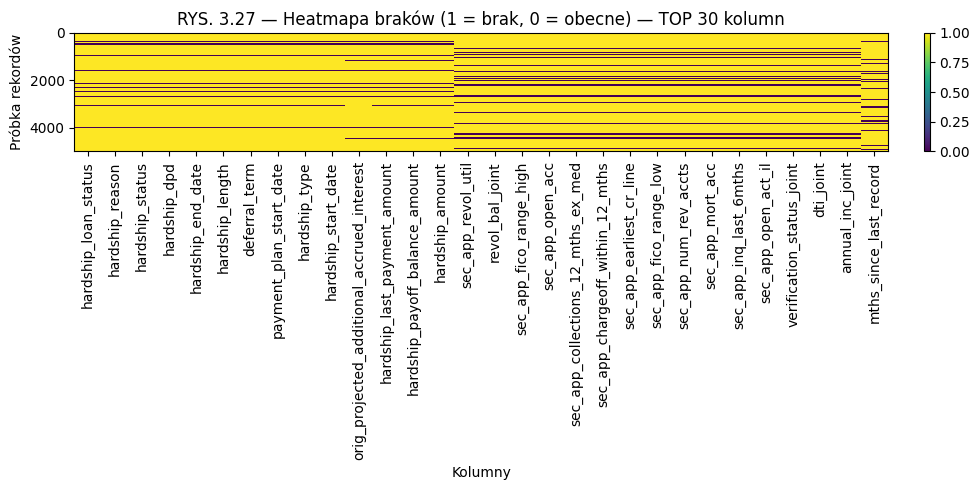


TAB. 3.7 — Korelacja flag 'missing' z loan_status_bin (TOP):


,corr_with_y
last_pymnt_d,0.072
hardship_flag,0.071
emp_title,0.049
emp_length,0.046
num_tl_120dpd_2m,0.038
title,0.014
mo_sin_old_il_acct,0.011
bc_open_to_buy,0.001
bc_util,0.001
dti,0.001



Prosta imputacja wykonana dla kolumn (num): ['annual_inc', 'dti', 'revol_util']
Prosta imputacja wykonana dla kolumn (cat): ['emp_length', 'home_ownership', 'purpose']

TAB. 3.8a — Podsumowanie imputacji (numeryczne):


,column,n_missing_before,n_missing_after,imputed_value
0,annual_inc,0,0,65000.00
1,dti,1711,0,18.05
2,revol_util,1587,0,49.30



TAB. 3.8b — Rozkład kategorii po imputacji: 'emp_length'


,count
emp_length,
10+ years,677437
2 years,182788
< 1 year,171702
3 years,162422
missing,137908
1 year,133374
4 years,122109
5 years,121970
6 years,88335



TAB. 3.8b — Rozkład kategorii po imputacji: 'home_ownership'


,count
home_ownership,
MORTGAGE,995479
RENT,799121
OWN,234352
ANY,996
NONE,4



TAB. 3.8b — Rozkład kategorii po imputacji: 'purpose'


,count
purpose,
debt_consolidation,1146650
credit_card,468324
home_improvement,136961
other,126119
major_purchase,44475
medical,25216
car,20447
small_business,19952
vacation,14216


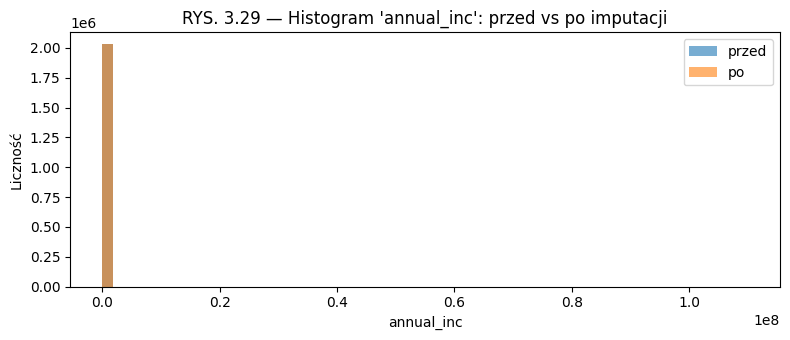


TAB. 3.9 — Imputacja segmentowa: annual_inc -> annual_inc_imp_seg (grupy: grade×term).


,annual_inc,annual_inc_imp_seg,grade,term
0,42000.0,42000.0,A,36 months
1,155000.0,155000.0,B,36 months
2,120000.0,120000.0,C,60 months
3,79077.0,79077.0,A,36 months
4,107000.0,107000.0,A,36 months



TAB. 3.10 — Imputacja zaawansowana: KNN i MICE — przykładowe kolumny:


,annual_inc,dti,revol_util,loan_amnt,int_rate,annual_inc_knn,dti_knn,revol_util_knn,loan_amnt_knn,int_rate_knn,annual_inc_mice,dti_mice,revol_util_mice,loan_amnt_mice,int_rate_mice
0,42000.0,27.74,37.0,12000.0,7.97,42000.0,27.74,37.0,12000.0,7.97,42000.0,27.74,37.0,12000.0,7.97
1,155000.0,12.35,34.1,32000.0,11.99,155000.0,12.35,34.1,32000.0,11.99,155000.0,12.35,34.1,32000.0,11.99
2,120000.0,31.11,20.7,40000.0,15.05,120000.0,31.11,20.7,40000.0,15.05,120000.0,31.11,20.7,40000.0,15.05



ANEKS A.1 — Kontrole jakości (podsumowanie):
 - duplicates_count: 0
 - constant_columns: ['pymnt_plan', 'policy_code']
 - int_rate_contains_percent_sign: 0.00%
 - revol_util_contains_percent_sign: 0.00%
 - ranges: {'int_rate_min_max_%': (5.31, 30.99), 'dti_min_max': (-1.0, 999.0)}


In [43]:
# ==========================================
# Analiza braków i jakości danych — Lending Club
# (z komentarzami: która tabela/rysunek jest czym)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Podsumowanie ogólne braków ---
n_rows, n_cols = DF.shape
missing_per_col = DF.isna().mean().sort_values(ascending=False)  # udział braków (0..1)
overall_missing = DF.isna().sum().sum() / DF.size

print(f"Liczba obserwacji: {n_rows:,} | liczba kolumn: {n_cols}")
print(f"Udział braków w całej macierzy: {overall_missing:.2%}")

# >>> TAB. 3.6: Udział braków i typ danych — TOP 20 zmiennych
info = (DF.dtypes.rename('dtype')
        .to_frame()
        .join(missing_per_col.rename('missing_rate'))
        .sort_values('missing_rate', ascending=False))
tab_top20 = info.head(20)
print("\nTAB. 3.6 — Udział braków i typ danych (TOP 20):")
display(tab_top20.style.format({'missing_rate':'{:.2%}'}))

# >>> RYS. 3.28: Udział braków (TOP 20) — wykres słupkowy
top20 = missing_per_col.head(20)
plt.figure(figsize=(9,4))
plt.bar(top20.index.astype(str), top20.values)
plt.xticks(rotation=90)
plt.ylabel('Udział braków')
plt.title('RYS. 3.28 — Udział braków (TOP 20 kolumn)')
plt.tight_layout(); plt.show()

# >>> RYS. 3.27: Heatmapa braków (1=brak) — TOP 30 kolumn
top30_cols = missing_per_col.head(30).index.tolist()
sample_n = min(5000, len(DF))
mask = DF[top30_cols].head(sample_n).isna().astype(int).values
plt.figure(figsize=(10,5))
im = plt.imshow(mask, aspect='auto', interpolation='nearest')
plt.title('RYS. 3.27 — Heatmapa braków (1 = brak, 0 = obecne) — TOP 30 kolumn')
plt.xlabel('Kolumny'); plt.ylabel('Próbka rekordów')
plt.xticks(range(len(top30_cols)), top30_cols, rotation=90)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# --- Flagi „missingness” a ryzyko (wersja odporna na ostrzeżenia) ---
# >>> TAB. 3.7: Flagi braków a ryzyko — korelacja z y (Pearson)
if 'loan_status_bin' in DF.columns:
    y = DF['loan_status_bin']
    miss_corr = {}

    for c in DF.columns:
        # flaga braku: 1 = brak, 0 = obecne
        f = DF[c].isna().astype('float64')

        # bierzemy tylko pary z nie-NaN w obu wektorach
        pair = pd.DataFrame({'flag': f, 'y': y}).dropna()

        # jeśli po docięciu flag albo y są stałe -> korelacja nie jest zdefiniowana
        if pair.empty or pair['flag'].nunique() < 2 or pair['y'].nunique() < 2:
            miss_corr[c] = np.nan
            continue

        # oblicz korelację (bez ostrzeżeń o dzieleniu przez zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            miss_corr[c] = pair['flag'].corr(pair['y'])

    miss_corr = pd.Series(miss_corr).sort_values(na_position='last', ascending=False)

    print("\nTAB. 3.7 — Korelacja flag 'missing' z loan_status_bin (TOP):")
    display(miss_corr.head(15).to_frame('corr_with_y').round(3))
else:
    print("\nTAB. 3.7 — pominięta (brak kolumny 'loan_status_bin').")

# --- Prosta imputacja: mediana / 'missing' ---
num_cols_example = [c for c in ['annual_inc','dti','revol_util'] if c in DF.columns]
cat_cols_example = [c for c in ['emp_length','home_ownership','purpose'] if c in DF.columns]

DF_simple_imp = DF.copy()
for c in num_cols_example:
    DF_simple_imp[c] = pd.to_numeric(DF_simple_imp[c], errors='coerce')
    med = DF_simple_imp[c].median()
    DF_simple_imp[c] = DF_simple_imp[c].fillna(med)
for c in cat_cols_example:
    DF_simple_imp[c] = DF_simple_imp[c].astype('object').fillna('missing')

print("\nProsta imputacja wykonana dla kolumn (num):", num_cols_example)
print("Prosta imputacja wykonana dla kolumn (cat):", cat_cols_example)

# >>> TAB. 3.8a: Podsumowanie imputacji (num) — n_missing_before/after + imputed_value
rows = []
for c in num_cols_example:
    before = DF[c].isna().sum()
    after  = DF_simple_imp[c].isna().sum()
    med    = DF_simple_imp[c].median()
    rows.append([c, before, after, med])
tab_imp_num = pd.DataFrame(rows, columns=['column','n_missing_before','n_missing_after','imputed_value'])
print("\nTAB. 3.8a — Podsumowanie imputacji (numeryczne):")
display(tab_imp_num)

# >>> TAB. 3.8b: Rozkład kategorii po imputacji ('missing') — cat
for c in cat_cols_example:
    print(f"\nTAB. 3.8b — Rozkład kategorii po imputacji: '{c}'")
    display(DF_simple_imp[c].value_counts(dropna=False).to_frame('count'))

# >>> RYS. 3.29: Histogram 'annual_inc' — przed vs po imputacji (porównanie rozkładów)
c = next((x for x in num_cols_example if x in DF_simple_imp.columns), None)
if c is not None:
    plt.figure(figsize=(8,3.5))
    plt.hist(pd.to_numeric(DF[c], errors='coerce').dropna(), bins=60, alpha=0.6, label='przed')
    plt.hist(pd.to_numeric(DF_simple_imp[c], errors='coerce').dropna(), bins=60, alpha=0.6, label='po')
    plt.title(f"RYS. 3.29 — Histogram '{c}': przed vs po imputacji")
    plt.xlabel(c); plt.ylabel('Liczność'); plt.legend()
    plt.tight_layout(); plt.show()

# --- Imputacja segmentowa (grade × term) ---
if set(['annual_inc','grade','term']).issubset(DF.columns):
    tmp = DF.copy()
    tmp['annual_inc'] = pd.to_numeric(tmp['annual_inc'], errors='coerce')
    term_num = tmp['term'].astype(str).str.extract(r'(\d+)')[0]
    grp_med = tmp.groupby([tmp['grade'], term_num])['annual_inc'].transform('median')
    tmp['annual_inc_imp_seg'] = tmp['annual_inc'].fillna(grp_med)

    # >>> TAB. 3.9: Imputacja segmentowa annual_inc — grade × term
    print("\nTAB. 3.9 — Imputacja segmentowa: annual_inc -> annual_inc_imp_seg (grupy: grade×term).")
    display(tmp[['annual_inc','annual_inc_imp_seg','grade','term']].head(5))
else:
    print("\nTAB. 3.9 — pominięta (brak wymaganych kolumn).")

# --- Imputacja zaawansowana: KNN / MICE (opcjonalnie) ---
try:
    from sklearn.impute import KNNImputer
    from sklearn.experimental import enable_iterative_imputer  # noqa
    from sklearn.impute import IterativeImputer

    adv_cols = [c for c in ['annual_inc','dti','revol_util','loan_amnt','int_rate'] if c in DF.columns]
    X = DF[adv_cols].apply(lambda s: pd.to_numeric(s, errors='coerce'))

    knn_imp = KNNImputer(n_neighbors=5, weights='distance')
    X_knn = pd.DataFrame(knn_imp.fit_transform(X), columns=adv_cols, index=X.index)

    mice_imp = IterativeImputer(random_state=42, max_iter=10, sample_posterior=False)
    X_mice = pd.DataFrame(mice_imp.fit_transform(X), columns=adv_cols, index=X.index)

    # >>> TAB. 3.10: Przykładowe wyniki imputacji KNN i MICE (porównanie)
    print("\nTAB. 3.10 — Imputacja zaawansowana: KNN i MICE — przykładowe kolumny:")
    display(pd.concat([X.head(3),
                       X_knn.head(3).add_suffix('_knn'),
                       X_mice.head(3).add_suffix('_mice')], axis=1))
except Exception as e:
    print("\nTAB. 3.10 — pominięta (brak scikit-learn lub błąd):", e)

# --- Kontrole jakości (Aneks) ---
report = {}
report['duplicates_count'] = int(DF.duplicated().sum())
const_cols = [c for c in DF.columns if DF[c].dropna().nunique() <= 1]
report['constant_columns'] = const_cols
for c in [c for c in ['int_rate','revol_util'] if c in DF.columns]:
    s = DF[c].astype(str).str.contains('%', na=False).mean()
    report[f'{c}_contains_percent_sign'] = f"{s:.2%}"
ranges = {}
if 'int_rate' in DF.columns:
    ir = pd.to_numeric(DF['int_rate'].astype(str).str.replace('%','', regex=False), errors='coerce')
    ranges['int_rate_min_max_%'] = (float(ir.min()), float(ir.max()))
if 'dti' in DF.columns:
    dti = pd.to_numeric(DF['dti'], errors='coerce')
    ranges['dti_min_max'] = (float(dti.min()), float(dti.max()))
report['ranges'] = ranges

# >>> ANEKS A.1: Raport jakości danych — lista kontrolna
print("\nANEKS A.1 — Kontrole jakości (podsumowanie):")
for k,v in report.items():
    print(f" - {k}: {v}")



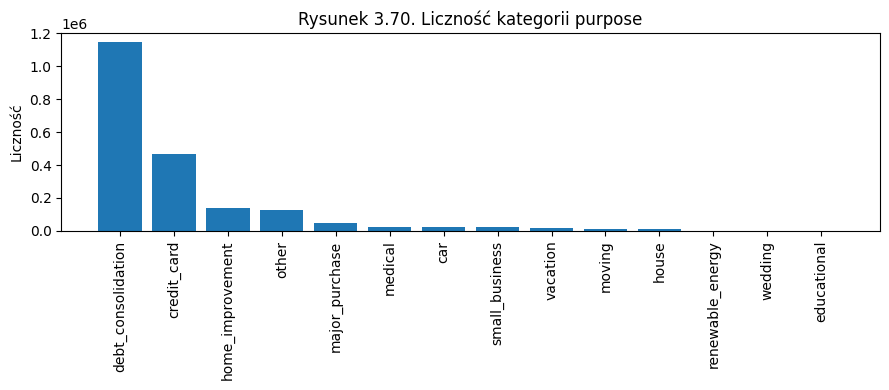

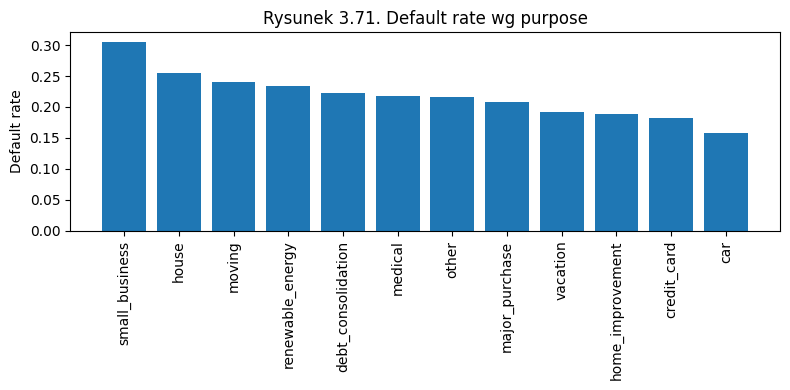

<Figure size 800x400 with 0 Axes>

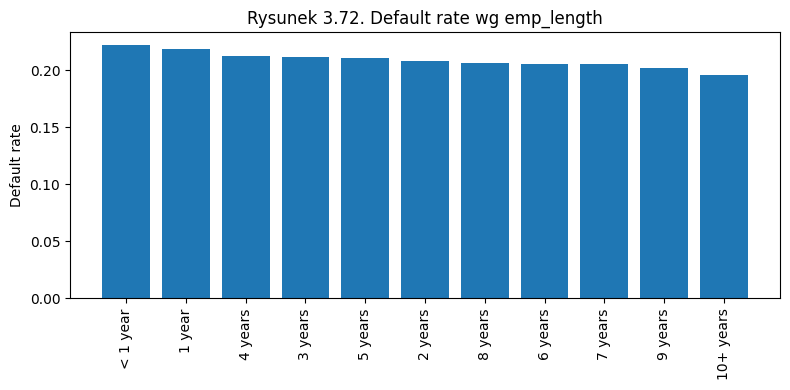

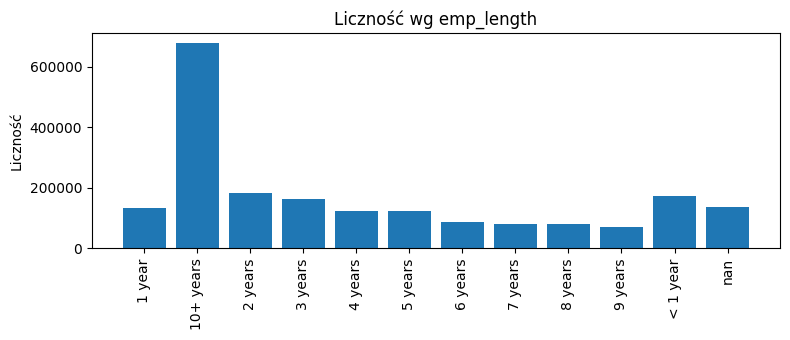

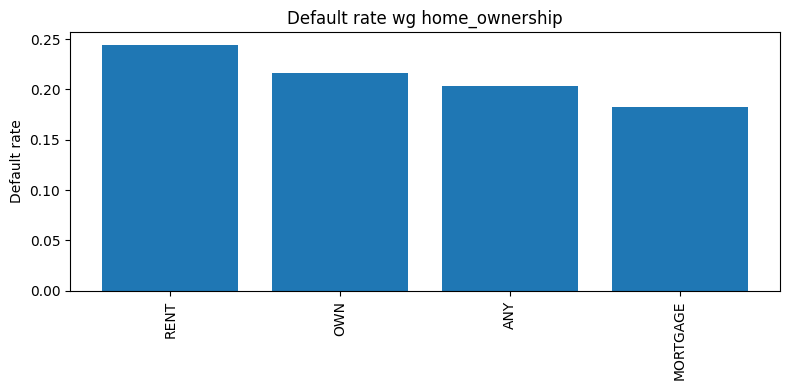

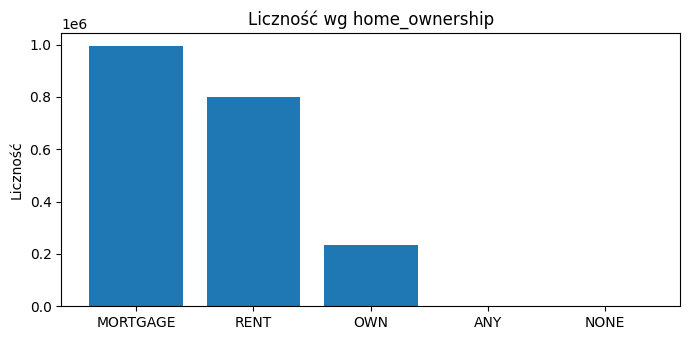

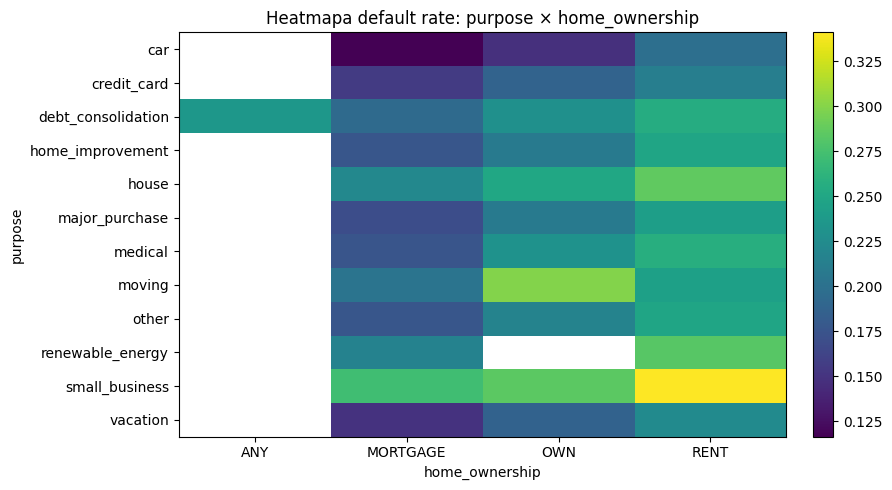

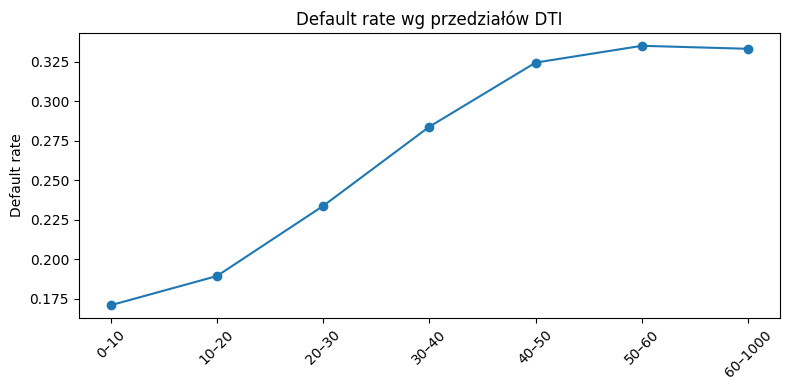

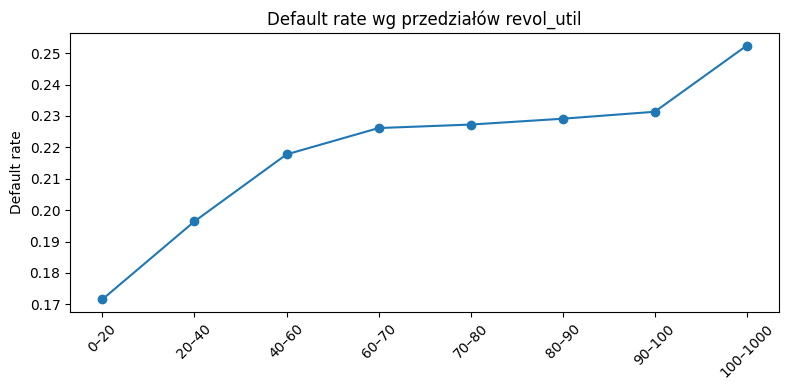

Tabela — Top segmenty wysokiego ryzyka (≥500 obserwacji):


,purpose,grade,term_num,income_bin,count,default_rate
205,debt_consolidation,G,60,≤40k,743,0.606999
195,debt_consolidation,F,60,≤40k,2278,0.564530
206,debt_consolidation,G,60,40–60k,1530,0.554248
196,debt_consolidation,F,60,40–60k,5039,0.531256
207,debt_consolidation,G,60,60–80k,1280,0.521094
126,credit_card,F,60,40–60k,615,0.520325
127,credit_card,F,60,60–80k,505,0.512871
208,debt_consolidation,G,60,80–120k,1148,0.505226
115,credit_card,E,60,≤40k,1231,0.504468
197,debt_consolidation,F,60,60–80k,4074,0.501964


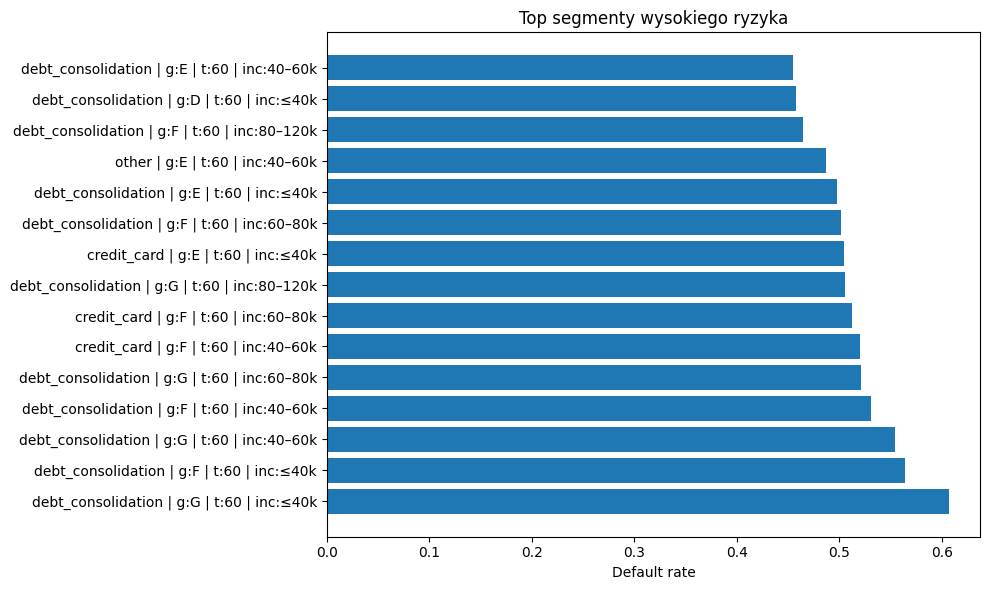

In [44]:


# --- TARGET (na wszelki wypadek) ---
if 'loan_status_bin' not in DF.columns and 'loan_status' in DF.columns:
    map_rules = {
        'Fully Paid': 0,
        'Charged Off': 1, 'Default': 1,
        'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 'In Grace Period': 1,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Does not meet the credit policy. Status:Charged Off': 1,
        'Current': np.nan, 'Issued': np.nan
    }
    DF['loan_status_bin'] = DF['loan_status'].map(map_rules)

def bar_default_rate(df, col, title, min_count=200, figsize=(8,4)):
    sub = df[[col, 'loan_status_bin']].dropna()
    counts = sub[col].value_counts()
    keep = counts[counts >= min_count].index
    sub = sub[sub[col].isin(keep)]
    rates = sub.groupby(col)['loan_status_bin'].mean().sort_values(ascending=False)
    plt.figure(figsize=figsize)
    plt.bar(rates.index.astype(str), rates.values)
    plt.xticks(rotation=90); plt.ylabel('Default rate'); plt.title(title)
    plt.tight_layout(); plt.show()
    return counts.loc[rates.index], rates

# === 3.70: liczność kategorii purpose ===
if 'purpose' in DF.columns:
    vc = DF['purpose'].astype('category').value_counts(dropna=False)
    plt.figure(figsize=(9,4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.xticks(rotation=90); plt.ylabel('Liczność')
    plt.title('Rysunek 3.70. Liczność kategorii purpose')
    plt.tight_layout(); plt.show()

# === 3.71: default rate wg purpose ===
if 'purpose' in DF.columns and 'loan_status_bin' in DF.columns:
    bar_default_rate(DF, 'purpose', 'Rysunek 3.71. Default rate wg purpose')

# === 3.72: default rate wg emp_length ===
if 'emp_length' in DF.columns:
    plt.figure(figsize=(8,4))
    counts, rates = bar_default_rate(DF, 'emp_length', 'Rysunek 3.72. Default rate wg emp_length')

# === 3.73: liczność emp_length (dla pary 3.72–3.73, jeśli potrzebne) ===
if 'emp_length' in DF.columns:
    vc = DF['emp_length'].astype(str).value_counts(dropna=False).sort_index()
    plt.figure(figsize=(8,3.5))
    plt.bar(vc.index.astype(str), vc.values)
    plt.xticks(rotation=90); plt.ylabel('Liczność')
    plt.title('Liczność wg emp_length')
    plt.tight_layout(); plt.show()

# === 3.74: default rate wg home_ownership ===
if 'home_ownership' in DF.columns:
    bar_default_rate(DF, 'home_ownership', 'Default rate wg home_ownership')

# === 3.75: liczność home_ownership ===
if 'home_ownership' in DF.columns:
    vc = DF['home_ownership'].astype(str).value_counts(dropna=False)
    plt.figure(figsize=(7,3.5))
    plt.bar(vc.index.astype(str), vc.values)
    plt.xticks(rotation=0); plt.ylabel('Liczność')
    plt.title('Liczność wg home_ownership')
    plt.tight_layout(); plt.show()

# === 3.76: heatmapa default rate: purpose × home_ownership ===
if set(['purpose','home_ownership','loan_status_bin']).issubset(DF.columns):
    sub = DF[['purpose','home_ownership','loan_status_bin']].dropna()
    # filtr minimalnej liczności, żeby nie szumiało
    size = sub.groupby(['purpose','home_ownership']).size()
    valid_pairs = size[size >= 200].index
    sub = sub.set_index(['purpose','home_ownership']).loc[valid_pairs].reset_index()
    mat = sub.pivot_table(index='purpose', columns='home_ownership',
                          values='loan_status_bin', aggfunc='mean')
    plt.figure(figsize=(9,5))
    im = plt.imshow(mat.values, aspect='auto', interpolation='nearest')
    plt.xticks(range(len(mat.columns)), mat.columns, rotation=0)
    plt.yticks(range(len(mat.index)), mat.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Heatmapa default rate: purpose × home_ownership')
    plt.xlabel('home_ownership'); plt.ylabel('purpose')
    plt.tight_layout(); plt.show()

# === 3.77–3.78: default rate w przedziałach DTI i revol_util ===
def binned_default_plot(df, num_col, bins, title):
    x = pd.to_numeric(df[num_col], errors='coerce')
    y = df['loan_status_bin']
    sub = pd.DataFrame({num_col: x, 'y': y}).dropna()
    band = pd.cut(sub[num_col], bins=bins)
    rate = sub.groupby(band)['y'].mean()
    plt.figure(figsize=(8,4))
    plt.plot(range(len(rate)), rate.values, marker='o')
    plt.xticks(range(len(rate)), [f'{b.left:.0f}–{b.right:.0f}' for b in rate.index], rotation=45)
    plt.ylabel('Default rate'); plt.title(title)
    plt.tight_layout(); plt.show()

if set(['dti','loan_status_bin']).issubset(DF.columns):
    bins = [0, 10, 20, 30, 40, 50, 60, 1000]
    binned_default_plot(DF, 'dti', bins, 'Default rate wg przedziałów DTI')

if set(['revol_util','loan_status_bin']).issubset(DF.columns):
    ru = DF['revol_util'].astype(str).str.replace('%','', regex=False)
    DF['_revol_util_num'] = pd.to_numeric(ru, errors='coerce')
    bins = [0, 20, 40, 60, 70, 80, 90, 100, 1000]
    binned_default_plot(DF.rename(columns={'_revol_util_num':'revol_util_num'}),
                        'revol_util_num', bins,
                        'Default rate wg przedziałów revol_util')

# === 3.79: Top segmenty wysokiego ryzyka (purpose, grade, term, income_bin) ===
# income_bin
if 'annual_inc' in DF.columns:
    inc = pd.to_numeric(DF['annual_inc'], errors='coerce')
    inc_bins = [-np.inf, 40000, 60000, 80000, 120000, np.inf]
    inc_labels = ['≤40k','40–60k','60–80k','80–120k','>120k']
    DF['income_bin'] = pd.cut(inc, bins=inc_bins, labels=inc_labels)

# term_num
if 'term' in DF.columns:
    DF['term_num'] = DF['term'].astype(str).str.extract(r'(\d+)')[0]

need_cols = ['purpose','grade','term_num','income_bin','loan_status_bin']
if all(c in DF.columns for c in need_cols):
    seg = DF[need_cols].dropna()
    grp = seg.groupby(['purpose','grade','term_num','income_bin'])['loan_status_bin']
    tab = pd.DataFrame({'count': grp.size(), 'default_rate': grp.mean()}).reset_index()
    top = tab[tab['count'] >= 500].sort_values('default_rate', ascending=False).head(15)

    # Tabela „Top segmenty wysokiego ryzyka”
    print("Tabela — Top segmenty wysokiego ryzyka (≥500 obserwacji):")
    display(top)

    # Rysunek 3.79 — poziomy wykres top 15
    plt.figure(figsize=(10,6))
    labels = (top['purpose'] + ' | g:' + top['grade'].astype(str) +
              ' | t:' + top['term_num'].astype(str) + ' | inc:' + top['income_bin'].astype(str))
    y_pos = np.arange(len(top))[::-1]
    plt.barh(y_pos, top['default_rate'].values[::-1])
    plt.yticks(y_pos, labels[::-1])
    plt.xlabel('Default rate'); plt.title('Top segmenty wysokiego ryzyka')
    plt.tight_layout(); plt.show()


In [45]:
# ============================================
# 3.2.9. Inżynieria cech — kod referencyjny (FIX: issue_d w snapshotcie)
# pandas, numpy, matplotlib (bez seaborn)
# ============================================
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", FutureWarning)

ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

MIN_COUNT_WOE = 200     # minimalna liczność koszyka do WOE/IV
N_QBINS       = 10      # liczba przedziałów kwantylowych
HIST_BINS     = 60      # liczba koszyków na histogramach

# ===== 1) Zmienna celu (y) =====
# Oczekujemy, że masz ramkę DF z oryginalnymi kolumnami Lending Club
if 'loan_status_bin' not in DF.columns:
    map_rules = {
        'Fully Paid': 0,
        'Charged Off': 1, 'Default': 1,
        'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 'In Grace Period': 1,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Does not meet the credit policy. Status:Charged Off': 1,
        'Current': np.nan, 'Issued': np.nan
    }
    DF['loan_status_bin'] = DF['loan_status'].map(map_rules)

df = DF.copy()

# ===== 2) Oczyszczanie podstawowych kolumn =====
def to_num_strip_pct(s):
    if s is None:
        return np.nan
    return pd.to_numeric(pd.Series(s).astype(str).str.replace('%','', regex=False), errors='coerce')

df['int_rate_num']   = to_num_strip_pct(df.get('int_rate', np.nan))
df['revol_util_num'] = to_num_strip_pct(df.get('revol_util', np.nan))

# --- daty w formacie "Jan-2015" itp. ---
def parse_ym_col(col):
    if col not in df.columns:
        return pd.Series(pd.NaT, index=df.index)
    parsed = pd.to_datetime(df[col], format='%b-%Y', errors='coerce')
    parsed = parsed.fillna(pd.to_datetime(df[col], errors='coerce'))
    return parsed

issue_dt = parse_ym_col('issue_d')
earl_dt  = parse_ym_col('earliest_cr_line')

# [NOWE] zapisz datę emisji jako kolumnę w ISO (ułatwia późniejsze parse_dates)
df['issue_d'] = issue_dt  # datetime64[ns]; przy zapisie CSV będzie sformatowana niżej

# ===== 3) Cechy inżynierskie =====
df['credit_history_years'] = (issue_dt - earl_dt).dt.days / 365.25

df['annual_inc_num'] = pd.to_numeric(df.get('annual_inc', np.nan), errors='coerce')
df['int_rate_log']   = np.log1p(df['int_rate_num'])
df['annual_inc_log'] = np.log1p(df['annual_inc_num'])

def safe_div(a, b):
    a = pd.to_numeric(a, errors='coerce')
    b = pd.to_numeric(b, errors='coerce')
    return np.where((b > 0) & np.isfinite(b), a / b, np.nan)

df['loan_to_income']        = safe_div(df.get('loan_amnt', np.nan),      df['annual_inc_num'])
df['installment_to_income'] = safe_div(df.get('installment', np.nan),    df['annual_inc_num'])
df['revol_to_income']       = safe_div(df.get('revol_bal', np.nan),      df['annual_inc_num'])

df['revol_util_capped'] = df['revol_util_num'].clip(lower=0, upper=150)

# ===== 4) Binning kwantylowy =====
qvars = ['loan_to_income', 'installment_to_income', 'revol_to_income']
for c in qvars:
    if c in df.columns:
        s = pd.to_numeric(df[c], errors='coerce')
        try:
            df[f'{c}_qbin'] = pd.qcut(s, q=N_QBINS, duplicates='drop')
        except Exception:
            df[f'{c}_qbin'] = pd.cut(s, bins=N_QBINS)

# ===== 5) Podsumowanie statystyczne =====
num_cols = [
    'int_rate_num','int_rate_log',
    'annual_inc_num','annual_inc_log',
    'credit_history_years',
    'loan_to_income','installment_to_income','revol_to_income',
    'revol_util_num','revol_util_capped'
]
num_cols = [c for c in num_cols if c in df.columns]

summary = pd.DataFrame({
    'n': df[num_cols].count(),
    'missing': df[num_cols].isna().sum(),
    'mean': df[num_cols].mean(),
    'std': df[num_cols].std(),
    'median': df[num_cols].median(),
    'min': df[num_cols].min(),
    'max': df[num_cols].max()
})
summary.to_csv(f'{ART_DIR}/table_feature_summary.csv', index=True)

# ===== 6) Wykresy =====
def hist_save(series, title, filename, bins=HIST_BINS):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if len(s) == 0:
        return
    plt.figure(figsize=(7,4))
    plt.hist(s, bins=bins)
    plt.title(title); plt.xlabel(series.name); plt.ylabel('Liczność')
    plt.tight_layout(); plt.savefig(f'{ART_DIR}/{filename}', dpi=160); plt.close()

hist_save(df['int_rate_num'],   'Histogram: int_rate',   'hist_int_rate.png')
hist_save(df['annual_inc_num'], 'Histogram: annual_inc', 'hist_annual_inc.png')

corr_cols = [c for c in num_cols if c in df.columns]
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr()
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, interpolation='nearest', aspect='auto')
    plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
    plt.yticks(range(len(corr_cols)), corr_cols)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Macierz korelacji — cechy inżynierskie (Pearson)')
    plt.tight_layout(); plt.savefig(f'{ART_DIR}/corr_engineered.png', dpi=160); plt.close()

# ===== 7) WOE / IV =====
def woe_iv_from_binned(df_in, x_bin_col, y_col='loan_status_bin', min_count=MIN_COUNT_WOE):
    d = df_in[[x_bin_col, y_col]].dropna()
    if d.empty:
        return pd.DataFrame(), np.nan
    vc = d[x_bin_col].value_counts()
    keep = vc[vc >= min_count].index
    d = d[d[x_bin_col].isin(keep)]
    if d.empty:
        return pd.DataFrame(), np.nan

    tab = d.groupby(x_bin_col, observed=True)[y_col].agg(['count','sum'])
    tab = tab.rename(columns={'sum':'bad'})
    tab['good'] = tab['count'] - tab['bad']
    good_all = tab['good'].sum()
    bad_all  = tab['bad'].sum()
    eps = 1e-6
    tab['good_rate'] = (tab['good'] / max(good_all, eps)).clip(eps, 1)
    tab['bad_rate']  = (tab['bad']  / max(bad_all,  eps)).clip(eps, 1)
    tab['WOE']       = np.log(tab['good_rate'] / tab['bad_rate'])
    tab['IV_contrib']= (tab['good_rate'] - tab['bad_rate']) * tab['WOE']
    IV_total = float(tab['IV_contrib'].sum())
    tab = tab.reset_index().rename(columns={x_bin_col: 'bin'})
    return tab, IV_total

woe_artifacts = []
for c in qvars:
    bin_col = f'{c}_qbin'
    if bin_col in df.columns:
        t, iv = woe_iv_from_binned(df, bin_col, y_col='loan_status_bin', min_count=MIN_COUNT_WOE)
        if not t.empty:
            out_csv = f'{ART_DIR}/table_woe_iv_{bin_col}.csv'
            t.to_csv(out_csv, index=False)
            woe_artifacts.append((bin_col, iv, out_csv))
            plt.figure(figsize=(8,4))
            plt.plot(range(len(t)), t['WOE'].values, marker='o')
            plt.xticks(range(len(t)), t['bin'].astype(str), rotation=45)
            plt.title(f'WOE dla {c} (IV={iv:.3f})'); plt.ylabel('WOE')
            plt.tight_layout(); plt.savefig(f'{ART_DIR}/woe_{bin_col}.png', dpi=160); plt.close()

if woe_artifacts:
    pd.DataFrame(woe_artifacts, columns=['binned_var','IV','csv_path']) \
      .sort_values('IV', ascending=False) \
      .to_csv(f'{ART_DIR}/woe_iv_summary.csv', index=False)
else:
    print("WOE/IV — brak (za mało danych lub brak binned vars po filtrze).")

# ===== 8) Snapshot gotowych cech (z issue_d) =====
engineered_cols = [
    # target
    'loan_status_bin',
    # ID — jeśli istnieje w danych, dorzucimy
    'id' if 'id' in df.columns else None,
    # data emisji
    'issue_d',
    # engineered numeric
    'int_rate_num','int_rate_log',
    'annual_inc_num','annual_inc_log',
    'credit_history_years',
    'loan_to_income','installment_to_income','revol_to_income',
    'revol_util_num','revol_util_capped',
    # binned
    'loan_to_income_qbin','installment_to_income_qbin','revol_to_income_qbin'
]
engineered_cols = [c for c in engineered_cols if c is not None and c in df.columns]

# zapis z ISO dla daty
snap_path = f'{ART_DIR}/engineered_snapshot.csv'
df_to_save = df[engineered_cols].copy()
if 'issue_d' in df_to_save.columns:
    df_to_save['issue_d'] = pd.to_datetime(df_to_save['issue_d']).dt.strftime('%Y-%m-%d')
df_to_save.to_csv(snap_path, index=False)

# [DODATKOWO] mapa id→issue_d (jeśli 'id' dostępne)
if 'id' in df.columns:
    id_map = df[['id','issue_d']].copy()
    id_map['issue_d'] = pd.to_datetime(id_map['issue_d']).dt.strftime('%Y-%m-%d')
    id_map.dropna(subset=['issue_d'], inplace=True)
    id_map.to_csv(f'{ART_DIR}/id_issue_map.csv', index=False)

print("Zapisano pliki w:", os.path.abspath(ART_DIR))
print(" - engineered_snapshot.csv (z kolumną issue_d)")
if 'id' in df.columns:
    print(" - id_issue_map.csv (id, issue_d) — pomocny do późniejszego merge’u")


C:\Users\lukasz.wrobel\AppData\Local\Temp\ipykernel_5640\3447824977.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = parsed.fillna(pd.to_datetime(df[col], errors='coerce'))


Zapisano pliki w: c:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\artifacts\artifacts
 - engineered_snapshot.csv (z kolumną issue_d)
 - id_issue_map.csv (id, issue_d) — pomocny do późniejszego merge’u


Pliki w artifacts/:
 - corr_engineered.png
 - engineered_snapshot.csv
 - hist_annual_inc.png
 - hist_int_rate.png
 - id_issue_map.csv
 - table_feature_summary.csv
 - table_woe_iv_installment_to_income_qbin.csv
 - table_woe_iv_loan_to_income_qbin.csv
 - table_woe_iv_revol_to_income_qbin.csv
 - woe_installment_to_income_qbin.png
 - woe_iv_summary.csv
 - woe_loan_to_income_qbin.png
 - woe_revol_to_income_qbin.png


,Unnamed: 0,n,missing,mean,std,median,min,max
0,int_rate_num,2029952,0,13.001448,4.872039,12.610000,5.310000,3.099000e+01
1,int_rate_log,2029952,0,2.580162,0.345091,2.610805,1.842136,3.465423e+00
2,annual_inc_num,2029952,0,78711.860149,117488.724924,65000.000000,0.000000,1.100000e+08
3,annual_inc_log,2029952,0,11.095522,0.646158,11.082158,0.000000,1.851599e+01
4,credit_history_years,2029952,0,16.529965,7.734700,14.921287,3.077344,8.325257e+01


,binned_var,IV,csv_path
0,loan_to_income_qbin,0.122296,artifacts/table_woe_iv_loan_to_income_qbin.csv
1,installment_to_income_qbin,0.101662,artifacts/table_woe_iv_installment_to_income_q...
2,revol_to_income_qbin,0.004286,artifacts/table_woe_iv_revol_to_income_qbin.csv


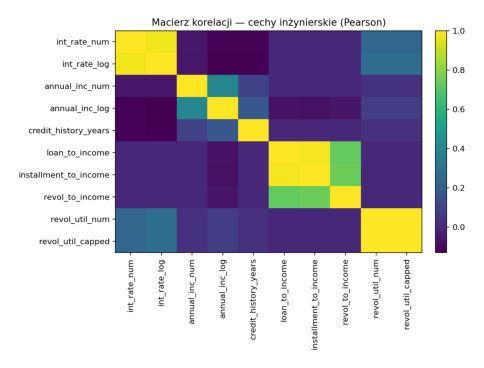

In [ ]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

print("Pliki w artifacts/:")
for p in sorted(glob.glob(f"{ART_DIR}/*")):
    print(" -", os.path.basename(p))

# podejrzyj podsumowanie cech
sum_path = f"{ART_DIR}/table_feature_summary.csv"
if os.path.exists(sum_path):
    display(pd.read_csv(sum_path).head())

# ranking IV
iv_path = f"{ART_DIR}/woe_iv_summary.csv"
if os.path.exists(iv_path):
    display(pd.read_csv(iv_path))

# pokaż heatmapę korelacji
img_path = f"{ART_DIR}/corr_engineered.png"
if os.path.exists(img_path):
    plt.figure(figsize=(6,5))
    plt.imshow(imread(img_path))
    plt.axis("off")
    plt.show()
 